Initial setup, imports

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import gymnasium as gym
import random
from queue import Queue
import time
import matplotlib.cm as cm
import pickle

[End of Pre-Training Setup](#end-of-setup)


[Create Env](#env-make)


[Create v3 Env](#v3-env-make)


[Create v4 Env](#v4-env-make)


[Create v4 Env - Custom Reward](#v4-new-reward-env-make)

In [46]:
class Node: #nodes feature coordinate system, wall boolean and neighbour list
    def __init__(self, row, col):
        self.row = row
        self.col = col
        self.neighbours=[]
        self.is_wall = True
        self.is_hazard = False
        self.is_exit = False
        self.is_spawn = False

class Map: #map containing grid of nodes, square based on map_size
    def __init__(self, map_size):
        self.grid = [[Node(row, col) for col in range(map_size)] for row in range(map_size)]
        self.size = map_size
        self.exit = None
        self.spawn = None

    def get_tile_info(self):

        ##tile info for NN input
        # 0 empty
        # 1 wall
        # 2 key
        # 3 exit
        # 4 player
        # 5 hazard
        # 6 enemy
        info_grid = [[-1 for col in range(self.size)] for row in range(map.size)]
        for row in range(self.size):
            for col in range(self.size):
                tile = self.grid[row][col]
                tile_info = -1
                #info_grid[row][col]self.grid[row][col]
                #insert into 3d array info
                if tile.is_exit:
                    tile_info = 3
                elif tile.is_hazard:
                    tile_info = 5
                elif tile.is_wall:
                    tile_info = 1
                else:
                    tile_info = 0
                info_grid[row][col] = tile_info

        return info_grid

        


class UnionFind: #unionFind algorithm for joining nodes
    def __init__(self, map):
        self.parent=[[(r, c) for c in range(map.size)] for r in range(map.size)] #parents are coordinates as id
        self.rank=[[0 for c in range(map.size)] for r in range(map.size)] #rank for union by rank
        
    def find(self, coord): #check parent of cnode by coordinate
        r, c = coord
        if self.parent[r][c] != coord: #if parent is not itself
            self.parent[r][c] = self.find(self.parent[r][c]) #find actual parent
        return self.parent[r][c] #return parent
    
    def union(self, coord1, coord2): #join two nodes
        #print("UNION: coord1:", coord1, "coord2:", coord2)
        root1 = self.find(coord1) #get parent of coord1
        root2 = self.find(coord2) #get parent of coord2

        #print("UNION: root1:", root1, "root2:", root2)
        if root1 != root2: #
            r1, c1 = root1
            r2, c2 = root2
            #print("RANKS: rank1 =", self.rank[r1][c1], ", rank2 =", self.rank[r2][c2])
            
            if self.rank[r1][c1] > self.rank[r2][c2]:
                self.parent[r2][c2] = root1
            elif self.rank[r1][c1] < self.rank[r2][c2]:
                self.parent[r1][c1] = root2
            else:
                self.parent[r2][c2] = root1
                self.rank[r1][c1] += 1

def createBareMap(size):
    map = Map(size)
    #iterate through map rows and cols
    for row in range(map.size):
        for col in range(map.size):
            node = map.grid[row][col]
            if row > 0:
                node.neighbours.append(map.grid[row - 1][col]) #north neighbour
            if row < map.size - 1:
                node.neighbours.append(map.grid[row + 1][col])  #south neighbour
            if col > 0:
                node.neighbours.append(map.grid[row][col - 1])  #west neighbour
            if col < map.size - 1:
                node.neighbours.append(map.grid[row][col + 1])  #east neighbour

    #set initial path cells
    for row in range(map.size):
        for col in range(map.size):
            if row % 2 == 1 and col % 2 == 1:
                map.grid[row][col].is_wall = False
    return map

def drawMap(map):
    for row in range(map.size):
            print(''.join('D' if node.is_exit else ('S' if node.is_spawn else (' ' if not node.is_wall else ('X' if node.is_hazard else  '#'))) for node in map.grid[row]))

def getEdges(map): #if first pass get every 2nd wall, allowing for perfect maze
    edges=[]
    for row in range(1, map.size, 2): #start at 1, step by two to only get path cells
        for col in range(1, map.size, 2):
            if row + 2 < map.size:  #vert wall
                wall = map.grid[row + 1][col]
                cell1 = map.grid[row][col]
                cell2 = map.grid[row + 2][col]
                edges.append((wall, cell1, cell2))  # (wall, cell1, cell2)
            if col + 2 < map.size:  #horizontal wall
                wall = map.grid[row][col + 1]
                cell1 = map.grid[row][col]
                cell2 = map.grid[row][col + 2]
                edges.append((wall, cell1, cell2))
    return edges

def getRemainingWalls(map):
    walls=[]
    for row in range(1, map.size - 1): 
            for col in range(1, map.size - 1):
                if map.grid[row][col].is_wall and map.grid[row][col].is_hazard == False: #avoid hazards
                    walls.append(map.grid[row][col]) #append wall
    return walls

def getRemainingPaths(map):
    paths=[]
    for row in range(1, map.size - 1): 
            for col in range(1, map.size - 1):
                if not map.grid[row][col].is_wall: #avoid walls and hazard walls
                    paths.append(map.grid[row][col])  #append path
    return paths
        
def removeWalls(uf, edges): #takes a unionfind and edge list
    for wall, cell1, cell2 in edges:
        coord1 = (cell1.row, cell1.col)
        coord2 = (cell2.row, cell2.col)
        if uf.find(coord1) != uf.find(coord2):
            uf.union(coord1, coord2)
            wall.is_wall = False

def isBoundary(node, map):
    if node.row == 0:
        return True
    elif node.row == map.size - 1:
        return True
    elif node.col == 0:
        return True
    elif node.col == map.size - 1:
        return True
    else:
        return False

#todo could add max dist/max_amount for distance based removal
def createCycles(cycle_bias, cluster_strength, cluster_type, map, sigmoid_slope, distance_type="sigmoid"):
    num_edges = 0
    remaining_walls = getRemainingWalls(map)
    num_cycles = np.floor(cycle_bias * len(remaining_walls))

    print("Cycle bias, num edges, num cycles: ", (cycle_bias, num_edges, num_cycles))

    random.shuffle(remaining_walls)
    print("map before cycles")
    drawMap(map)
    counter = 0

    for wall in remaining_walls: #get a wall and remove it
        if counter < num_cycles:
            wall.is_wall = False
            counter += 1

            match cluster_type: #cluster removal of walls based on input, centred on removed wall
                case "pocket":
                    nearest=[]
                    for row in range(wall.row - 2, wall.row + 3):
                        for col in range(wall.col - 2, wall.col + 3):
                            if row < map.size and row > 0 and col < map.size and col > 0:                            
                                if map.grid[row][col].is_wall and not isBoundary(map.grid[row][col], map) and map.grid[row][col].is_hazard == False:
                                    nearest.append(map.grid[row][col])
                    for close_wall in nearest:
                        if random.random() < cluster_strength:
                            close_wall.is_wall = False
                            counter += 1

                case "distance": #flood fill search across map for walls
                    visited = {(wall.row, wall.col)}
                    #todo maybe make a list of queued? maybe not necessary
                    q = Queue()
                    for neighbour in wall.neighbours:
                        q.put(neighbour)

                    #iterate through neighbours and add new neighbours
                    while q.empty() != True and counter < num_cycles:
                        next = q.get() #get next node from neighbours
                        if next in visited:
                            continue
                        for next_neighbour in next.neighbours: #add new neighbours if not visted before
                            if (next_neighbour.row, next_neighbour.col) not in visited and not isBoundary(next_neighbour, map):
                                q.put(next_neighbour) #add node's neighbours to queue

                        if next.is_wall == True and not isBoundary(next, map) and next.is_hazard == False: #if current node is a wall, get coords
                            x1, y1 = wall.row, wall.col
                            x2, y2 = next.row, next.col
                            dist = abs(x1 - x2) + abs(y1 - y2)
                            match distance_type:
                                case "manhattan":
                                     if random.random() < (cluster_strength / dist): #manhattan distance reduction of removal chance
                                        next.is_wall = False #remove wall if chance succeeds
                                        counter += 1

                                case _: #sigmoid distance
                                     #manhattan distance with inverse sigmoid function
                                     if random.random() < (cluster_strength / (1 + np.exp(sigmoid_slope * (dist - map.size / 2)))): 
                                        next.is_wall = False #remove wall if chance succeeds
                                        counter += 1

                        visited.add((next.row, next.col)) #add the node we've just been through to visited set          

                case _:
                    #no clustering needed by default
                    continue
        else:
            break
    


#function to randomly select some walls to turn to hazards
def addHazards(map, hazardLevel):
    remaining_walls = getRemainingWalls(map)
    random.shuffle(remaining_walls)

    for i in range(0, hazardLevel):
        remaining_walls[i].is_hazard = True

#in progress todo
#def addEntities(map, enemyLevel, entityOptions):
    #remaining_paths = getRemainingPaths(map)
    #random.shuffle(remaining_paths)

    #for i in range(0, 3): #minor objectives
    #create classes?
    #lists attached to map?
    #attach to tile?





In [47]:
def createCycleMap(size, cycle_bias, cluster_strength, cluster_type, sigmoid_slope=1, 
                   seed=-1, hazardLevel = 0, distance_type="sigmoid"):
    #init the map with size
    map = createBareMap(size)
    print("map before mazing")
    drawMap(map)
    #creating list of edges for kruskal
    edges = getEdges(map)
    #shuffle edges
    if seed != -1:
        random.seed(seed)    
    random.shuffle(edges)
    uf = UnionFind(map)  #start unionfind with a map
    removeWalls(uf, edges) #creates perfect maze
    addHazards(map, hazardLevel) #add hazards via remaining walls, ensuring level viability
    #creates non perfect maze
    createCycles(cycle_bias, cluster_strength, cluster_type, map, sigmoid_slope, distance_type)
    print("map after cycles")
    drawMap(map)
    spawnAndReturnDoor(map) 
    print("map after door")
    drawMap(map)
    return map

#function returns statistics on openness of generated map, as well as open tile list
def getOpenTiles(map):
    maxOpenTiles = (map.size - 4) * (map.size - 4)
    openTileCount = 0
    openTiles = []
    for row in range(map.size):
        for col in range(map.size):
            tile = map.grid[row][col]
            if tile.is_wall == False and all(neighbour.is_wall == False for neighbour in tile.neighbours):
                openTileCount += 1
                openTiles.append(tile)
    return (openTileCount, (openTileCount / maxOpenTiles), openTiles)

#function for spawning a door within map
def spawnAndReturnDoor(map, target=None):
    '''openTiles = getOpenTiles(map)[2]
    print(openTiles)
    random.shuffle(openTiles)'''
    pathTiles = []
    for row in range(map.size):
        for col in range(map.size):
            tile = map.grid[row][col]
            if tile.is_wall == False:
                pathTiles.append(tile)
    if(target):
        door = target
        door.is_exit = True
        map.exit = door
    else:
        random.shuffle(pathTiles)
        door = pathTiles[0]
        door.is_exit = True
        map.exit = door
    return door

#function to spawn player spawn on map, makes sure it is not exit tile
def spawnAndReturnSpawn(map, target=None):
    pathTiles = []
    for row in range(map.size):
        for col in range(map.size):
            tile = map.grid[row][col]
            if tile.is_wall == False and tile.is_exit == False:
                pathTiles.append(tile)
    if(target):
        spawn = target
        if spawn.is_exit or spawn.is_wall:
            print("Spawn is targeted at either the exit or wall, redefine.")
            spawn = pathTiles[0]
            spawn.is_spawn = True
            map.spawn = spawn
        spawn.is_spawn = True
        map.spawn = spawn
    else:
        random.shuffle(pathTiles)
        spawn = pathTiles[0]
        spawn.is_spawn = True
        map.spawn = spawn
    return spawn

                
                
                

In [48]:
map = createCycleMap(15, 0.5, 1, "distance", seed=81, hazardLevel=5)
print(getOpenTiles(map))



map before mazing
###############
# # # # # # # #
###############
# # # # # # # #
###############
# # # # # # # #
###############
# # # # # # # #
###############
# # # # # # # #
###############
# # # # # # # #
###############
# # # # # # # #
###############
Cycle bias, num edges, num cycles:  (0.5, 0, 33.0)
map before cycles
###############
#         X # #
##### # # # # #
#   # # #     #
# # # ##### # #
# #     # X # #
# ### # # #####
# #   #       #
#####X### ##X #
#     #   #   #
# ######### ###
#   #         #
# # ######X # #
# #         # #
###############
map after cycles
###############
#         X # #
#     # # # # #
#     # #     #
#     ##### # #
#       # X # #
#       # #####
#             #
#    X    ##X #
#         #   #
#       ### ###
#             #
#     ####X # #
#           # #
###############
map after door
###############
#         X # #
#     # # # # #
#     # #     #
#     ##### # #
#       # XD# #
#       # #####
#             #
#    X    ##X #
#         #   #
#

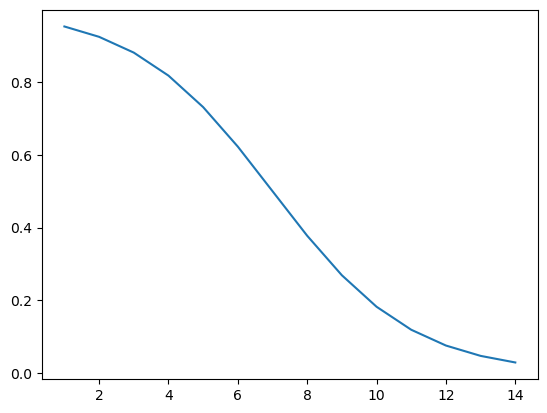

In [49]:
import matplotlib.pyplot as plt

#distances up to map.size
distances = np.arange(1, 15)
sigmoid_slope = 0.5

def sigmoid(distances, max_dist):
    result = 1 /(1 + np.exp(sigmoid_slope * (distances - (max_dist / 2)))) #inverse sigmoid with slope coefficient
    return result

max_dist = np.max(distances)
y = sigmoid(distances, max_dist)

fig, ax = plt.subplots()
ax.plot(distances, y)


In [50]:
#agent class 
class Agent:
    def __init__(self, startLocation, init_health = 10):
        self.init_health = init_health #initial health value
        self.health = init_health
        self.init_location = startLocation
        self.location = startLocation #start node
        self.hasKey = False #bool for key

    #reset function for agent
    def _reset(self):
        self.health = self.init_health
        self.location = self.init_location
        self.hasKey = False

#map options class to simplify map creation
class MapOptions:
    def __init__(self, size=15, cycle_bias=1, cluster_strength=0, cluster_type=None, sigmoid_slope=1, 
                 seed=-1, hazard_level=0, distance_type="sigmoid", is_base_map=True):
        self.size = size
        self.cycle_bias = cycle_bias
        self.cluster_strength = cluster_strength
        self.cluster_type = cluster_type
        self.sigmoid_slope = sigmoid_slope
        self.seed = seed
        self.hazard_level = hazard_level
        self.distance_type = distance_type
        self.is_base_map = is_base_map

#class storing history data for an episode on map
class EpHistory:
    def __init__(self, agent_locations:  list[(int, int)], exit_location: tuple[(int, int)], reward_history=None):
        self.agent_locations = agent_locations
        self.exit_location = exit_location
        self.reward_history = reward_history

#class to store ep histories across all training
class TrainingHistory:
    def __init__(self, iteration_histories: list[list[EpHistory]]):
        self.iteration_histories = iteration_histories
    
#class to set reward values for training
class RewardSettings:
    def __init__(self, exit_reward : float = 50, unvisited_reward = 0.1, hazard_reward : float = -2, wall_reward : float = -0.1, death_reward = -50, stuck_reward: float = 0):
        self.exit_reward = exit_reward
        self.unvisited_reward = unvisited_reward
        self.hazard_reward = hazard_reward  #(punishment)
        self.wall_reward = wall_reward  #(punishment)
        self.death_reward = death_reward #(punishment)
        self.stuck_reward = stuck_reward #(punishment)

In [67]:
from enum import Enum

from typing import Optional

import pygame

#defining env
class GridWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode = None, max_steps=100, obs_mode="init", init_map_options = None, reward_settings: RewardSettings = None):

        self.max_steps = max_steps #max steps per episode
        self.current_step = 0 #init step counter

        #set obs mode
        self.obs_mode = obs_mode

        #use created map or default
        if init_map_options == None:
            init_map_options = MapOptions() #bare map
        self.map = self.create_and_return_map(init_map_options)

        #use rewardsettings or create
        if reward_settings == None:
            reward_settings = RewardSettings()
        self.reward_settings = reward_settings 

        #grid and render size
        self.size = self.map.size
        self.window_size = 512

        #define base locations for agent and exit, #todo update in step and in reset
        self._init_location = self.map.spawn
        self._exit_location = self.map.exit
        #self._exit_location = np.array([-1, -1], dtype=np.int32)

        #list of visited coordinates for a run
        self.visited = []
        self.visited.append((self._init_location.col, self._init_location.row))

        self.action_history = [] #tracking intended actions

        self._agent = Agent(self._init_location)

        #todo, redefine with new obs space
        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`-1}^2
        self.observation_space = gym.spaces.Dict(
            {
                "agent": gym.spaces.Box(0, self.size - 1, shape=(2,), dtype=int),
                "target": gym.spaces.Box(0, self.size - 1, shape=(2,), dtype=int),
                "tile_info": gym.spaces.Box(0, 6, shape=(15, 15), dtype=int)
            }


        )

        #todo, redefine action space to work with node based movement
        # We have 4 actions, corresponding to "right", "up", "left", "down"
        self.action_space = gym.spaces.Discrete(4)
        # Dictionary maps the abstract actions to the directions on the grid
        '''
        self._action_to_direction = {
            0: np.array([1, 0]),  # right
            1: np.array([0, 1]),  # up
            2: np.array([-1, 0]),  # left
            3: np.array([0, -1]),  # down
        }
        '''
        self._action_to_direction = {
        0: (0, 1),   # Right
        1: (-1, 0),  # Up
        2: (0, -1),  # Left
        3: (1, 0),   # Down        
        }

        #make sure initialised with some correct render mode
        assert (render_mode is None or render_mode in self.metadata["render_modes"])
        self.render_mode = render_mode

        self.window = None
        self.clock = None

    def create_and_return_map(self, options: MapOptions):
        # init the map with size
        map = createBareMap(options.size)
        # print("map before mazing")
        # drawMap(map)
        # creating list of edges for kruskal
        edges = getEdges(map)
        # shuffle edges
        if options.seed != -1:
            random.seed(options.seed)
        random.shuffle(edges)
        uf = UnionFind(map)  # start unionfind with a map
        removeWalls(uf, edges)  # creates perfect maze
        addHazards(map, options.hazard_level)  # add hazards via remaining walls, ensuring level viability
        # creates non perfect maze
        createCycles(options.cycle_bias, options.cluster_strength, options.cluster_type, 
                    map, options.sigmoid_slope, options.distance_type)
        #if base map then specify door location
        if(options.is_base_map):
            exit_tile = map.grid[13][13]
            spawnAndReturnDoor(map, exit_tile) 
        else:
            spawnAndReturnDoor(map) #else random generation

        #if base map then specify spawn location
        if(options.is_base_map):
            spawn_tile = map.grid[1][1]
            spawnAndReturnSpawn(map, spawn_tile) 
        else:
            spawnAndReturnSpawn(map) #else random generation
        return map
    
    #function to 
    def set_new_map(self, map):
        self.map = map
        self.reset()

    #function to initialise agent and entities in map
    #def init_after_map(self):
        #self.agent_location = spawn_agent()
    
    #todo, redefine with obs space
    def get_obs(self):

        if self.obs_mode == "init":
            return {"agent": self._agent.location, "target": self._exit_location}
        elif self.obs_mode == "v2":
            ##tile info for NN input
            # 0 empty
            # 1 wall
            # 2 key
            # 3 exit
            # 4 player
            # 5 hazard
            # 6 enemy
            current_map_state = self.map.get_tile_info()
            current_map_state[self._agent.location.row][self._agent.location.col] = 4
            #todo implement enemies and keys locations
            return {"agent": self._agent.location, 
                    "target": self._exit_location, 
                    "tile_info": current_map_state}
        elif self.obs_mode == "v3":
            ##tile info for NN input
            # 0 empty
            # 1 wall
            # 2 key
            # 3 exit
            # 4 player
            # 5 hazard
            # 6 enemy
            current_map_state = self.map.get_tile_info()
            current_map_state[self._agent.location.row][self._agent.location.col] = 4
            #todo implement enemies and keys locations
            return {"agent": self._agent.location, 
                    "target": self._exit_location, 
                    "tile_info": current_map_state, 
                    "agent_health": self._agent.health}
        elif self.obs_mode == "v4":
            #using one hot encoding for map state
            current_map_state = self.map.get_tile_info()

            agent_pos = (self._agent.location.col, self._agent.location.row)

            tile_info_one_hot = self.tile_info_to_one_hot(current_map_state, agent_pos)

            return {
                "agent": self._agent.location,
                "target": self._exit_location,
                "tile_info": tile_info_one_hot,
                "agent_health": self._agent.health,
            }
        else:
            return {"agent": self._agent.location, "target": self._exit_location} #else default to init
    #todo, redefine with necessary info - aux info returned in env.step()
    '''def _get_info(self):
        return {
            "distance": np.linalg.norm(
                self._init_location - self._exit_location, ord=1
            )
        }
    '''

    def tile_info_to_one_hot(self, tile_info: list[list[int]], agent_pos: tuple[int, int], num_classes: int = 7):
        tile_array = np.array(tile_info, dtype=np.int32)
        rows, cols = tile_array.shape
        num_channels = num_classes + 1  #last channel for agent

        one_hot = np.zeros((num_channels, rows, cols), dtype=np.float32)

        #populate rows and cols of one hot array channels
        for row in range(rows):
            for col in range(cols):
                tile_type = tile_array[row, col]
                if 0 <= tile_type < num_classes:
                    one_hot[tile_type, row, col] = 1.0

        #extra channel for agent
        agent_col, agent_row = agent_pos
        one_hot[num_classes, agent_row, agent_col] = 1.0

        return one_hot

    #manhattan distance of agent to target
    def _get_info(self):
        return {
            "distance": abs(self._agent.location.col - self._exit_location.col) + 
                        abs(self._agent.location.row - self._exit_location.row)
        }
    
    #return current env map
    def get_map(self):
        return self.map
    
    #todo redefine to properly reset locations etc
    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        self._init_location = self.map.spawn
        self._agent.location = self.map.spawn
        self._exit_location = self.map.exit

        self._agent.health = self._agent.init_health #heal

        observation = self.get_obs()
        info = self._get_info()

        self.current_step = 0 #reset steps

        self.action_history = []
        self.visited = [] #reset visited tiles
        self.visited.append((self._init_location.col, self._init_location.row))

        return observation, info
    
    #todo redefine to properly handle locations, actions, etc
    def step(self, action):

        #get agent loc
        current_row = self._agent.location.row
        current_col = self._agent.location.col

        #map the action (element of {0,1,2,3}) to the direction we walk in
        row_change, col_change = self._action_to_direction[action]

        #compute new loc
        new_row = current_row + row_change
        new_col = current_col + col_change

        exit_reward = self.reward_settings.exit_reward #setting for exit reward tuning
        unvisited_reward = self.reward_settings.unvisited_reward #setting for tuning exploration reward

        wall_reward = self.reward_settings.wall_reward #setting for tuning wall hit reward (punishment)
        hazard_reward = self.reward_settings.hazard_reward #setting for tuning hazard hit reward (punishment)
        death_reward = self.reward_settings.death_reward #setting for agent death reward (punishment)
        stuck_reward = self.reward_settings.stuck_reward

        reward_for_step = 0
        
        dead = False
        reached_exit = False
        terminated = False

        #check in bounds
        if(1 <= new_row < self.size - 1 and 1 <= new_col < self.size - 1):
            potential_node = self.map.grid[new_row][new_col]

            #keeping track of intended action history
            if (potential_node.col, potential_node.row) not in self.action_history:
                self.action_history.append((potential_node.col, potential_node.row))
            else:
                #check if last 5 actions match the current intended action
                intended_action = np.array([potential_node.col, potential_node.row])
                if np.all(self.action_history[-5:] == intended_action, axis=1).all():
                    reward_for_step += stuck_reward
                    
            #check for wall
            if not potential_node.is_wall:
                self._agent.location = potential_node

                #reward for exploration of non visited tiles
                if (self._agent.location.col, self._agent.location.row) not in self.visited:
                    self.visited.append((self._agent.location.col, self._agent.location.row))
                    reward_for_step += unvisited_reward

            #check for hazard
            elif potential_node.is_hazard:
                
                self._agent.health = self._agent.health - 2 #damage from hazard
                reward_for_step += hazard_reward #punish from hazard

                #death check and punish
                if self._agent.health <= 0:
                    reward_for_step += death_reward
                    dead = True
                
            #just wall
            else:
                reward_for_step += wall_reward
        else:
            reward_for_step += wall_reward

        

        #todo play with reward
        #environment completes if reach target
        reached_exit = (self._agent.location.row == self._exit_location.row and 
              self._agent.location.col == self._exit_location.col)
        
        #ensures always some reward, reward scales with max steps and encourages faster completions as reward scales with steps taken
        if reached_exit:
            reward_for_step += (exit_reward - (self.current_step * (exit_reward / self.max_steps))) + 1 
            
        if reached_exit or dead:
            terminated = True
        
        self.current_step += 1
        truncated = self.current_step >= self.max_steps

        observation = self.get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()
        
        #add location history for history tracking
        agent_location = (self._agent.location.col, self._agent.location.row)

        return observation, reward_for_step, terminated, truncated, info, agent_location
    
    ####################### RENDERING SECTION
    def render(self):
        if self.render_mode == "rgb_array" or self.render_mode == "human":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode(
                (self.window_size, self.window_size)
            )
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.size
        ) #the size of a single grid square in pixels

        #init pygame font for rendering
        pygame.font.init()
        font = pygame.font.SysFont(None, int(pix_square_size * 0.8))

        #first we draw the exit door
        exit_x, exit_y = pix_square_size * self._exit_location.col, pix_square_size * self._exit_location.row
        exit_rect = pygame.Rect((exit_x, exit_y), (pix_square_size, pix_square_size))
        pygame.draw.rect(canvas, (125, 90, 45), exit_rect)
        pygame.draw.rect(canvas, (0, 0, 0), exit_rect, 2)
        exit_text = font.render("D", True, (195, 160, 115))
        text_rect = exit_text.get_rect(center=(exit_x + pix_square_size / 2, exit_y + pix_square_size / 2))
        canvas.blit(exit_text, text_rect)
        '''
        pygame.draw.rect(
            canvas,
            (125, 90, 45),
            pygame.Rect(
                (pix_square_size * self._exit_location.col, pix_square_size * self._exit_location.row),
                (pix_square_size, pix_square_size),
            ),
        )
        '''

        #now we draw the agent
        pygame.draw.circle(
            canvas,
            (0, 150, 25),
            ((self._agent.location.col + 0.5) * pix_square_size, (self._agent.location.row + 0.5) * pix_square_size),
            pix_square_size / 3,
        )

        #draw walls / hazard
        for row in range(0, self.map.size):
            for col in range(0, self.map.size):
                cell = self.map.grid[row][col]
                x, y = pix_square_size * col, pix_square_size * row
                rect = pygame.Rect((x, y), (pix_square_size, pix_square_size))

                if cell.is_hazard:
                    pygame.draw.rect(canvas, (170, 160, 160), rect)
                    pygame.draw.rect(canvas, (0, 0, 0), rect, 2)
                    text = font.render("X", True, (255, 0, 0))
                    text_rect = text.get_rect(center=(x + pix_square_size / 2, y + pix_square_size / 2))
                    canvas.blit(text, text_rect)
                elif cell.is_wall:
                    pygame.draw.rect(canvas, (70, 70, 70), rect)
                    pygame.draw.rect(canvas, (0, 0, 0), rect, 2)
        '''
        for row in range(0, self.map.size):
            for col in range(0, self.map.size):
                if self.map.grid[row][col].is_hazard:
                    pygame.draw.rect(
                        canvas,
                        (255, 0, 0),
                        pygame.Rect(
                            (pix_square_size * col, pix_square_size * row),
                            (pix_square_size, pix_square_size),
                        ),
                    )
                elif self.map.grid[row][col].is_wall:
                    pygame.draw.rect(
                        canvas,
                        (0, 0, 0),
                        pygame.Rect(
                            (pix_square_size * col, pix_square_size * row),
                            (pix_square_size, pix_square_size),
                        ),
                    )
        '''
        
        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )


    #rendering heatmap of history
    def render_history(self, history: list[list[EpHistory]], heatmap: bool = False, save_heatmap: bool = False, save_path="heatmap.png"):

        

        if self.window is None:
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        
        if self.clock is None:
            self.clock = pygame.time.Clock()
        
        #size of grid square in pixels
        pix_square_size = self.window_size / self.size  

        #init pygame font for map rendering
        pygame.font.init()
        font = pygame.font.SysFont(None, int(pix_square_size * 0.8))

        #static surface
        static_surface = pygame.Surface((self.window_size, self.window_size))
        static_surface.fill((255, 255, 255))  

        #todo might (definitely) need to fix this to redraw for each episode at some point
        #target / exit
        exit_x, exit_y = pix_square_size * self._exit_location.col, pix_square_size * self._exit_location.row
        exit_rect = pygame.Rect((exit_x, exit_y), (pix_square_size, pix_square_size))
        pygame.draw.rect(static_surface, (125, 90, 45), exit_rect)
        pygame.draw.rect(static_surface, (0, 0, 0), exit_rect, 2)
        exit_text = font.render("D", True, (195, 160, 115))
        text_rect = exit_text.get_rect(center=(exit_x + pix_square_size / 2, exit_y + pix_square_size / 2))
        static_surface.blit(exit_text, text_rect)
        '''
        pygame.draw.rect(
            static_surface,
            (125, 90, 45),
            pygame.Rect(
                (pix_square_size * history.iteration_histories[0][0].exit_location[0], pix_square_size * history.iteration_histories[0][0].exit_location[1]), #todo possibly fix when multiple levels
                (pix_square_size, pix_square_size),
            ),
        )
        '''
        
        #draw walls / hazard
        for row in range(self.size):
            for col in range(self.size):
                cell = self.map.grid[row][col]
                x, y = pix_square_size * col, pix_square_size * row
                rect = pygame.Rect((x, y), (pix_square_size, pix_square_size))

                if cell.is_hazard:
                    pygame.draw.rect(static_surface, (170, 160, 160), rect)
                    pygame.draw.rect(static_surface, (0, 0, 0), rect, 2)
                    text = font.render("X", True, (255, 0, 0))
                    text_rect = text.get_rect(center=(x + pix_square_size / 2, y + pix_square_size / 2))
                    static_surface.blit(text, text_rect)
                elif cell.is_wall:
                    pygame.draw.rect(static_surface, (70, 70, 70), rect)
                    pygame.draw.rect(static_surface, (0, 0, 0), rect, 2)
        '''
        for row in range(self.size):
            for col in range(self.size):
                if self.map.grid[row][col].is_hazard:
                    pygame.draw.rect(
                        static_surface,
                        (255, 0, 0),  
                        pygame.Rect((pix_square_size * col, pix_square_size * row), (pix_square_size, pix_square_size)),
                    )
                elif self.map.grid[row][col].is_wall:
                    pygame.draw.rect(
                        static_surface,
                        (0, 0, 0),  
                        pygame.Rect((pix_square_size * col, pix_square_size * row), (pix_square_size, pix_square_size)),
                    )'
        '''

        #gridlines
        for x in range(self.size + 1):
            pygame.draw.line(static_surface, (0, 0, 0), (0, pix_square_size * x), (self.window_size, pix_square_size * x), width=2)
            pygame.draw.line(static_surface, (0, 0, 0), (pix_square_size * x, 0), (pix_square_size * x, self.window_size), width=2)

        #loop for drawing agent movement
        if not heatmap:
            for iteration in history.iteration_histories:
                for episode in iteration:
                    for step in episode.agent_locations:

                        x, y = step #unpack step agent location col and row

                        canvas = static_surface.copy()

                        # Now we draw the agent
                        pygame.draw.circle(
                            canvas,
                            (0, 150, 25),  
                            ((x + 0.5) * pix_square_size, (y + 0.5) * pix_square_size),
                            pix_square_size / 3,
                        )

                        self.window.blit(canvas, (0, 0))
                        pygame.event.pump()
                        pygame.display.update()

                        #human rendering rate
                        self.clock.tick(self.metadata["render_fps"] * 5)
                    
        else:  # is heatmap
            #create a 2D array to store movement frequency
            heatmap_array = np.zeros((self.size, self.size), dtype=np.float32)
            #fix naming?
            for iteration in history.iteration_histories:
                #count visits per grid cell
                for episode in iteration:
                    for step in episode.agent_locations:
                        x, y = step  #unpack col and row agent
                        heatmap_array[x, y] += 1  #increase visit count for this cell


            #normalize values to range 0-1
            max_value = heatmap_array.max()

            if max_value > 0:
                heatmap_array /= max_value

            #heatmap color gradient
            colormap = cm.get_cmap("jet")

            #apply color map to heatmap array
            heatmap_colored = colormap(heatmap_array) #(x size, y size, rgba channels)

            #unvisited tiles to transparent with 0 alpha
            heatmap_colored[heatmap_array == 0] = [0, 0, 0, 0]  # (R, G, B, Alpha)

            #convert to (x sizem y size, 3 channel)
            heatmap_rgb = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)  #extract rgb channels and convert to 255
            heatmap_alpha = (heatmap_colored[:, :, 3] * 255).astype(np.uint8)  #extract 4th channel convert to 255

            #merg rgb and alpha
            heatmap_rgba = np.zeros((heatmap_rgb.shape[0], heatmap_rgb.shape[1], 4), dtype=np.uint8)
            heatmap_rgba[:, :, 0] = heatmap_rgb[:, :, 0]  #red
            heatmap_rgba[:, :, 1] = heatmap_rgb[:, :, 1]  #green
            heatmap_rgba[:, :, 2] = heatmap_rgb[:, :, 2]  #blue
            heatmap_rgba[:, :, 3] = heatmap_alpha #alpha


            #overlay heatmap surface
            #heatmap_surface = pygame.surfarray.make_surface(heatmap_rgba)  
            #heatmap_surface = pygame.transform.scale(heatmap_surface, (self.window_size, self.window_size)) #resize to fit window

            heatmap_rgba_swapped = np.swapaxes(heatmap_rgba, 0, 1)

            #convert np array to bytes (flattened 1D arr)
            heatmap_bytes = heatmap_rgba_swapped.tobytes()

            #create a pygame surface with the correct RGBA format
            heatmap_surface = pygame.image.frombuffer(heatmap_bytes, (heatmap_rgba.shape[0], heatmap_rgba.shape[1]), "RGBA")

            #resize heatmap surface to match the window size
            heatmap_surface = pygame.transform.scale(heatmap_surface, (self.window_size, self.window_size))

            

            #final heatmap
            self.window.blit(static_surface, (0, 0))  #draw background first
            self.window.blit(heatmap_surface, (0, 0))  #overlay heatmap

            #redraw exit
            exit_x, exit_y = pix_square_size * self._exit_location.col, pix_square_size * self._exit_location.row
            exit_rect = pygame.Rect((exit_x, exit_y), (pix_square_size, pix_square_size))
            pygame.draw.rect(self.window, (125, 90, 45), exit_rect)
            pygame.draw.rect(self.window, (0, 0, 0), exit_rect, 2)
            exit_text = font.render("D", True, (195, 160, 115))
            text_rect = exit_text.get_rect(center=(exit_x + pix_square_size / 2, exit_y + pix_square_size / 2))
            self.window.blit(exit_text, text_rect)

            #save heatmap as image
            if(save_heatmap):
                pygame.image.save(self.window, save_path)
                print(f"Heatmap saved as {save_path}")

            pygame.display.update()
            time.sleep(5) #todo remove




    #todo close doesnt work after step code finishes, works if used in same code block
    def close(self):
        if self.window is not None:
            print("window is not none")
            pygame.display.quit()
            pygame.quit()

# Env Make

In [68]:
from gymnasium.envs.registration import register


register(
    id="GridWorld-v0",  #id
    entry_point="__main__:GridWorldEnv",
    max_episode_steps=100,
)

c:\Users\anon\anaconda3\Lib\site-packages\gymnasium\envs\registration.py:642: UserWarning: WARN: Overriding environment GridWorld-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [53]:
env = gym.make("GridWorld-v0", max_episode_steps=100, obs_mode="v2").unwrapped
env.render()
#observation, info = env.reset()

#print("Initial Observation:", observation)

drawMap(env.get_map())

env.get_obs()
            ##tile info for NN input
            # 0 empty
            # 1 wall
            # 2 key
            # 3 exit
            # 4 player
            # 5 hazard
            # 6 enemy

Cycle bias, num edges, num cycles:  (1, 0, 72.0)
map before cycles
###############
# #       #   #
# ##### ### ###
# #     #   # #
# # ##### # # #
# #     # #   #
# # ######### #
#   #         #
# ### ##### ###
#         #   #
### ##### # # #
#   #   # # # #
# # # # # ### #
# # # #     # #
###############
###############
#S            #
#             #
#             #
#             #
#             #
#             #
#             #
#             #
#             #
#             #
#             #
#             #
#            D#
###############


{'agent': <__main__.Node at 0x1f92f681850>,
 'target': <__main__.Node at 0x1f92f610f80>,
 'tile_info': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [54]:
env.reset()

({'agent': <__main__.Node at 0x1f92f681850>,
  'target': <__main__.Node at 0x1f92f610f80>,
  'tile_info': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   [1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
   [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1],
   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]},
 {'distance': 24})

In [55]:
env.close()

In [56]:
#test right
'''
obs = env.step(0)
print(obs)
print(obs[0]["agent"].row, obs[0]["agent"].col)
'''


'\nobs = env.step(0)\nprint(obs)\nprint(obs[0]["agent"].row, obs[0]["agent"].col)\n'

In [57]:
#test up
'''
obs = env.step(1)
print(obs)
print(obs[0]["agent"].row, obs[0]["agent"].col)
'''

'\nobs = env.step(1)\nprint(obs)\nprint(obs[0]["agent"].row, obs[0]["agent"].col)\n'

In [58]:
#test left
'''
obs = env.step(2)
print(obs)
print(obs[0]["agent"].col, obs[0]["agent"].row)
'''



'\nobs = env.step(2)\nprint(obs)\nprint(obs[0]["agent"].col, obs[0]["agent"].row)\n'

In [59]:
#test down
'''
obs = env.step(3)
print(obs)
print(obs[0]["agent"].row, obs[0]["agent"].col)
'''

'\nobs = env.step(3)\nprint(obs)\nprint(obs[0]["agent"].row, obs[0]["agent"].col)\n'

In [60]:

'''
#test down
obs = env.step(3)
print(obs)
print(obs[0]["agent"].row, obs[0]["agent"].col)
time.sleep(1)
#test down
obs = env.step(3)
print(obs)
print(obs[0]["agent"].row, obs[0]["agent"].col)
time.sleep(1)
#test down
obs = env.step(3)
print(obs)
print(obs[0]["agent"].row, obs[0]["agent"].col)
time.sleep(1)

#test down
obs = env.step(0)
print(obs)
print(obs[0]["agent"].row, obs[0]["agent"].col)
time.sleep(1)
#test down
obs = env.step(0)
print(obs)
print(obs[0]["agent"].row, obs[0]["agent"].col)
time.sleep(1)
#test down
obs = env.step(0)
print(obs)
print(obs[0]["agent"].row, obs[0]["agent"].col)
time.sleep(1)
'''


'\n#test down\nobs = env.step(3)\nprint(obs)\nprint(obs[0]["agent"].row, obs[0]["agent"].col)\ntime.sleep(1)\n#test down\nobs = env.step(3)\nprint(obs)\nprint(obs[0]["agent"].row, obs[0]["agent"].col)\ntime.sleep(1)\n#test down\nobs = env.step(3)\nprint(obs)\nprint(obs[0]["agent"].row, obs[0]["agent"].col)\ntime.sleep(1)\n\n#test down\nobs = env.step(0)\nprint(obs)\nprint(obs[0]["agent"].row, obs[0]["agent"].col)\ntime.sleep(1)\n#test down\nobs = env.step(0)\nprint(obs)\nprint(obs[0]["agent"].row, obs[0]["agent"].col)\ntime.sleep(1)\n#test down\nobs = env.step(0)\nprint(obs)\nprint(obs[0]["agent"].row, obs[0]["agent"].col)\ntime.sleep(1)\n'

In [61]:
def random_action(): #purely random up down left or right
    return np.random.randint(0, 4)

def r_or_d_random_action(): #purely random right or down
    return np.random.randint(0, 2)

#One step using simple baselines, no model
def play_one_step_simple(env, obs, type=0):
    if isinstance(obs, tuple):
        obs = obs[0]
    with tf.GradientTape() as tape:
        obs_reshaped = np.expand_dims(obs, axis=0)
        action = -1
        match type:
            case 0:
                action = random_action() #random [0, 1]
            case 1:
                action = r_or_d_random_action()
                if action == 1: #second output
                    action = 3 #change from up to down
            case _:
                raise ValueError("Not a valid simple action type.")
        obs, reward, terminated, truncated, info, agent_location = env.step(action)
        return obs, terminated

'''
#Post Training method for a step with model
def play_one_step_no_train(env, obs, model):
    if isinstance(obs, tuple):
        obs = obs[0]
    with tf.GradientTape() as tape:
        obs_reshaped = np.expand_dims(obs, axis=0)
        left_proba = model(obs_reshaped)
        action = (0.5 > left_proba)
        obs, reward, terminated, truncated, info = env.step(int(action[0, 0].numpy()))
        return obs, terminated
'''

#Method for manual testing of multiple episodes, with or without model
#simpleType may be 0, 1, 2 : 0 = random, 1 = If left, go right, vice versa. 2 = same, but with velocity checks.
def play_multiple_episodes_no_train(env, n_episodes, n_max_steps, model=None, simpleType=0):
    steps=[]
    for episode in range(n_episodes):
        obs = env.reset()
        for step in range(n_max_steps):
            if(model == None):
                obs, terminated = play_one_step_simple(env, obs, simpleType) #no model, simple baselines
            #else:
            #    obs, terminated = play_one_step_no_train(env, obs, model)#pre trained model use
            if terminated:
                break
        steps.append(step)
    return steps

In [62]:
#hist = play_multiple_episodes_no_train(env, 1, 100, simpleType=1)
#print(hist)

In [63]:
##############
# Policy Gradient Model Disclaimer
# SOME functions have been adapted with own changes and additions, from outdated tutorial code:
# [1] A. Géron, Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems.
# Sebastopol, UNITED STATES: O’Reilly Media, Incorporated, 2019. Accessed: Nov. 06, 2024. [Online]. Available: http://ebookcentral.proquest.com/lib/goldsmiths/detail.action?docID=5892320
    
#play one step using environment step function, observations, and model predictions
def play_one_step(env, obs, model, loss_fn, exploration_policy, exp_scale, debug_action_list):
    if isinstance(obs, tuple):
        obs = obs[0]

    agent_col, agent_row = obs["agent"].col, obs["agent"].row 
    exit_col, exit_row = obs["target"].col, obs["target"].row
    #pos data
    position_data = np.array([agent_col, agent_row, exit_col, exit_row], dtype=np.float32)
    obs_numeric = position_data

    #get coords from nodes
    if env.obs_mode == "v2":
        info_grid_np = np.array(obs["tile_info"], dtype=np.float32).flatten()
        obs_numeric = np.concatenate([position_data, info_grid_np], axis=0)

    if env.obs_mode == "v3" or env.obs_mode == "v4":
        info_grid_np = np.array(obs["tile_info"], dtype=np.float32).flatten()
        agent_health = np.array([obs["agent_health"]], dtype=np.float32)
        obs_numeric = np.concatenate([position_data, info_grid_np, agent_health], axis=0)


        
    #obs_numeric = np.array([agent_col, agent_row, exit_col, exit_row], dtype=np.float32)


    with tf.GradientTape() as tape:
        obs_reshaped = np.expand_dims(obs_numeric, axis=0)

        action_probs = model(obs_reshaped) #get probs for all 4 actions from model

        action = -1
        match exploration_policy:
            case "epsilon":
                action = select_action_epsilon_greedy(action_probs, exp_scale) #epsilon greedy
            case "boltzmann":
                action = select_action_boltzmann(action_probs, exp_scale) #boltzmann decision
            case "debug_queue":
                action = debug_action_list.pop(0)
            case _:
                action = tf.argmax(action_probs, axis=1).numpy()[0] #greedy decision

        y_target = tf.one_hot(action, depth=4, dtype=tf.float32) #one hot encoded target
        y_target = tf.expand_dims(y_target, axis=0) #expand dims to fit probs vector
        
        loss = tf.reduce_mean(loss_fn(y_target, action_probs)) # calc loss
        grads = tape.gradient(loss, model.trainable_variables)
        obs, reward, terminated, truncated, info, agent_location = env.step(action)
        return obs, reward, terminated, truncated, grads, agent_location
    
def select_action_epsilon_greedy(action_probs, epsilon=0.1):
    if np.random.rand() < epsilon:  
        return np.random.choice(4)  # Random action (exploration)
    else:
        return tf.argmax(action_probs, axis=1).numpy()[0]  # Greedy action
    
def select_action_boltzmann(action_probs, temperature):
    probs = action_probs.numpy().flatten()
    epsilon = 1e-8 #small to avoid 0
    safe_probs = np.clip(probs, epsilon, 1.0) #clip with epsilon to avoid log(0)
    logits = np.log(safe_probs) / temperature #convert to logits first for temperature scaling
    exp_logits = np.exp(logits) #now exp
    boltzmann_probs = exp_logits / np.sum(exp_logits) #e(p/T) / sum(e(p/T))
    action = np.random.choice(len(boltzmann_probs), p=boltzmann_probs)
    return action

#mutliple episodes using play one step, return rewards and gradients lists from all episodes
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn, exploration_policy, exp_scale, debug_action_list):
    all_rewards = []
    all_grads = []
    all_histories = []
    #all_locations = [] #for movement history
    for episode in range(n_episodes):

        #
        current_rewards = []
        current_grads = []
        current_locations = [] #movement history
        obs, info = env.reset()

        if debug_action_list != None:
            debug_action_list_copy = debug_action_list.copy() #copy to keep queue for next episode
        else:
            debug_action_list_copy = None

        #create EpHistory
        ep_history = EpHistory(agent_locations=[], exit_location=(obs["target"].col, obs["target"].row), reward_history=[])

        #add initial location
        current_locations.append((env.get_obs()["agent"].col, env.get_obs()["agent"].row)) 

        for step in range(n_max_steps):
            obs, reward, terminated, truncated, grads, agent_location = play_one_step(env, obs, model, loss_fn, exploration_policy, exp_scale, debug_action_list_copy)
            current_rewards.append(reward)
            current_grads.append(grads)
            current_locations.append(agent_location)
            if terminated or truncated:
                break
        
        ep_history.agent_locations = current_locations
        ep_history.reward_history = current_rewards

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
        all_histories.append(ep_history)
        #all_locations.append(current_locations)
    return all_rewards, all_grads, all_histories #,all_locations

##helper to discount rewards to mitigate affect of past actions on future ones
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) -2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

#helper function to normalise discounted rewards
def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std() + 1e-8
    return [(discounted_rewards - reward_mean) / reward_std
           for discounted_rewards in all_discounted_rewards]
'''
#reusable training method for PolicyGradient model - with adjustable hyper parameter config object
def PolicyGradientTrain(env, model, config):
    optimizer = keras.optimizers.Adam(learning_rate=config.learning_rate)
    reward_history = [] #overall training reward history

    
    for iteration in range(config.n_iterations): #1 iteration = multiple episodes of simulation
        print("iteration ",iteration)

        if (config.exploration_policy == "boltzmann"): #scale temperature by episode
            exp_scale = max(0.1, config.exp_scale * (0.98 ** iteration))
        #play multiple episodes, get rewards and gradients
        all_rewards, all_grads, all_locations = play_multiple_episodes(env, config.n_episodes_per_update, config.n_max_steps,
                                                    model, config.loss_fn, config.exploration_policy, exp_scale)
        #reward tracking, by episode
        ep_reward_list = []
        for ep_reward in all_rewards:
            ep_reward_list.append(np.sum(ep_reward))
        reward_history.append(ep_reward_list)
        #todo fix history only returning one episode
        history = EpHistory(agent_locations=all_locations, exit_location=(env.get_map().exit.col, env.get_map().exit.row), reward_history=reward_history)

        #discount and normalize rewards
        all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       config.discount_factor)
        all_mean_grads=[]
        for var_index in range(len(model.trainable_variables)):
            mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
            for episode_index, final_rewards in enumerate(all_final_rewards)
                for step, final_reward in enumerate(final_rewards)], axis=0)
            all_mean_grads.append(mean_grads)
        optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))
    return history
'''

#reusable training method for PolicyGradient model - with adjustable hyper parameter config object
def PolicyGradientTrain(env, model, config):
    
    optimizer = keras.optimizers.Adam(learning_rate=config.learning_rate)
    iteration_histories = [] #list of iteration histories
    
    env.reset()
    print("new model visited: ", env.visited)
    print("new model obs - agent:", (env.get_obs()["agent"].col, env.get_obs()["agent"].row))
    print("new model obs - exit:", (env.get_obs()["target"].col, env.get_obs()["target"].row))

    
    for iteration in range(config.n_iterations): #1 iteration = multiple episodes of simulation
        print("iteration ",iteration)

        #scale for exploration policy - boltzmann calculated
        exp_scale = config.exp_scale
        if (config.exploration_policy == "boltzmann"): #scale temperature by iteration
            exp_scale = max(0.1, config.exp_scale * (0.99 ** iteration))

        #play multiple episodes, get rewards and gradients
        all_rewards, all_grads, all_histories = play_multiple_episodes(env, config.n_episodes_per_update, config.n_max_steps,
                                                    model, config.loss_fn, config.exploration_policy, exp_scale, config.debug_action_list)

        #compile list of histories for each episode
        iteration_histories.append(all_histories)

        #discount and normalize rewards
        all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       config.discount_factor)
        all_mean_grads=[]
        for var_index in range(len(model.trainable_variables)):
            mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
            for episode_index, final_rewards in enumerate(all_final_rewards)
                for step, final_reward in enumerate(final_rewards)], axis=0)
            all_mean_grads.append(mean_grads)
        optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

    #whole history container
    history = TrainingHistory(iteration_histories=iteration_histories)
    return history

#config class for model training, with default values that should be sufficient for the task.
#Max score for cartpole is 199
class TrainingConfig:
    def __init__(self, n_iterations=150, n_episodes_per_update=10, n_max_steps=200, discount_factor=0.95,
                 learning_rate=0.01, loss_fn=keras.losses.CategoricalCrossentropy(from_logits=False), model_type="PG", 
                 batch_size=32, DQNEpisodes=600, description: str = "no_train_desc_given", exploration_policy = "epsilon",
                 exp_scale = 0.1, debug_action_list: list[int] = None):
        self.n_iterations = n_iterations
        self.n_episodes_per_update = n_episodes_per_update
        self.n_max_steps = n_max_steps
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.loss_fn = loss_fn
        self.model_type = model_type
        self.batch_size = batch_size
        self.DQNEpisodes = DQNEpisodes
        self.description = description
        self.exploration_policy = exploration_policy
        self.exp_scale = exp_scale
        self.debug_action_list = debug_action_list


#class for building a model with config options dynamically
class ModelConfig:
    def __init__(self, layer_config=[5], activation="elu", n_inputs=4, n_outputs=4, out_activation="softmax", description: str = "no_model_desc_given"): #inputs generally 4 for this environment
        self.layer_config = layer_config
        self.activation = activation
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.out_activation = out_activation
        self.description = description

In [64]:
#####################
# DEEP Q-Learning
# Adapted with own changes and additions, from outdated tutorial code:
# [1] A. Géron, Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems.
# Sebastopol, UNITED STATES: O’Reilly Media, Incorporated, 2019. Accessed: Nov. 06, 2024. [Online]. Available: http://ebookcentral.proquest.com/lib/goldsmiths/detail.action?docID=5892320

###TODO FIX DQN TO WORK WITH HEATMAP HISTORY
from collections import deque

replay_buffer = deque(maxlen=2000)

#epsilon greedy policy encourages exploration using change, decreases as time goes on
def epsilon_greedy_policy(model, state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else :
        if isinstance(state, tuple):
            state = state[0]
        state_reshaped = np.expand_dims(state, axis=0)
        Q_values = model.predict(state_reshaped, verbose=0) #verbose = 0 for efficiency
        return np.argmax(Q_values[0])

#Return a selection of experiences from the replay buffer for training step
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]

     # Standardize state to array
    states = [experience[0][0] if isinstance(experience[0], tuple) else experience[0] for experience in batch]
    actions = np.array([experience[1] for experience in batch])
    rewards = np.array([experience[2] for experience in batch])
    next_states = [experience[3][0] if isinstance(experience[3], tuple) else experience[3] for experience in batch]
    dones = np.array([experience[4] for experience in batch])

    return np.array(states), actions, rewards, np.array(next_states), dones

#Play one step for the DQN model, rely on epsilon greedy policy and update replay buffer with experience
def play_one_step_DQN(model, env, state, epsilon):
    action = epsilon_greedy_policy(model, state, epsilon) #get action
    next_state, reward, terminated, truncated, info, agent_location = env.step(action) #perform step
    replay_buffer.append((state, action, reward, next_state, terminated)) #update experience
    return next_state, reward, terminated, info

#training step for DQN, get experiences and target Q values, update weights
def training_step(config, optimizer, model, n_outputs):
    experiences = sample_experiences(config.batch_size)
    states, actions, rewards, next_states, terminations = experiences

    next_Q_values = model.predict(next_states, verbose=0) #verbose = 0 for efficiency
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - terminations) * config.discount_factor * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(config.loss_fn(target_Q_values, Q_values))
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

#training loop helper function for DQN
#first 50 steps are no training to fill replay buffer, then training steps begin
def DeepQTrain(env, model, config, n_outputs):
  optimizer = keras.optimizers.Adam(learning_rate=config.learning_rate)
  reward_history=[]
  for episode in range(config.DQNEpisodes):
      print(episode)
      obs = env.reset()
      episode_reward=[]
      for step in range(config.n_max_steps):
          epsilon = max(1 - episode/(config.DQNEpisodes * (5/6)), 0.01) #epsilon strength decreases over time
          obs, reward, terminated, info = play_one_step_DQN(model, env, obs, epsilon)
          episode_reward.append(reward)
          if terminated:
              break
          if episode > 50:
              training_step(config, optimizer, model, n_outputs)
      reward_history.append(np.sum(episode_reward))
  return reward_history

In [65]:

#function to build and train a model based on config options
def BuildAndTrainModel(env, trainingConfig, modelConfig):
    model = keras.models.Sequential() #init model

    #input layer
    model.add(keras.layers.Dense(modelConfig.layer_config[0],
                                 activation=modelConfig.activation,
                                 input_shape=[modelConfig.n_inputs]))

    #add all middle layers
    for neurons in modelConfig.layer_config[1:]:
        model.add(keras.layers.Dense(neurons, activation=modelConfig.activation))

    model.add(keras.layers.Dense(modelConfig.n_outputs, activation=modelConfig.out_activation)) #output layer

    #train and return history
    history = []
    if(trainingConfig.model_type == "PG"):
        history = PolicyGradientTrain(env, model, trainingConfig)
    elif(trainingConfig.model_type == "DQN"):
        history = DeepQTrain(env, model, trainingConfig, modelConfig.n_outputs)
    elif(trainingConfig.model_type == "DQN_target"):
        target = keras.models.clone_model(model) 
        target.set_weights(model.get_weights())
        history = DeepQTrain_target(env, target, model, trainingConfig, modelConfig.n_outputs)
    else:
        raise ValueError("Not a valid model type.")
    return history, model

#function to set up a loop to build and train multipel models, returning lists of histories and models
def BuildAndTrainMultipleModels(env, trainConfigs, modelConfigs):
    #if config list lengths dont match, throw error
    if(len(trainConfigs) != len(modelConfigs)):
        raise ValueError("Length of config lists do not match.")
    else:
        histories={} #reward history for each training session
        models={} #models kept in dict
        i = 0
        for trCon, modCon in zip(trainConfigs, modelConfigs): #enumerate through both training and model config lists
            

            history, model = BuildAndTrainModel(env, trCon, modCon) #Build and train model, return trained model and reward history
            print(f"model_{modCon.description}_train_{trCon.description} built and trained.")
            histories[f"model_{modCon.description}_train_{trCon.description}_hist"] = history #append model reward history
            models[f"model_{modCon.description}_train_{trCon.description}"] = model #name model for dict
            i += 1
        return histories, models

In [23]:
#function for plotting reward histories from multiple models
def PlotRewardHistory(histories, title, marker="o", isPG=True, save_fig: bool = False):
    plt.figure(figsize=(12, 6))
    for key, value in histories.items():

        if(isPG):
            mean_history = []
            #mean_history = [np.mean(iteration.reward_history) for iteration in value] #take the average of rewards for each training episode
            for iteration in value.iteration_histories:
                total_rewards = [sum(episode.reward_history) for episode in iteration]

                mean_rewards = np.mean(total_rewards)

                mean_history.append(mean_rewards)
                
            #mean_history = [np.mean([episode.reward_history for episode in iteration]) for iteration in value.iteration_histories] #take the average of rewards for each training episode
            plt.plot(mean_history, marker=marker, label=f"{key} Mean Reward")
        else:
            plt.plot(value.reward_history, marker=marker, label=f"{key} Episode Reward")

    plt.xlabel("Episode Index")
    if(isPG):
        plt.ylabel("Mean Reward for Episode")
    else:
        plt.ylabel("Total Reward for Episode")
    plt.title(f"Reward History - {title}")
    plt.legend(loc="upper left", bbox_to_anchor=(0, -0.1), fontsize=12)

    fig_title = title.replace(" ", "_") #make file name safe
    if(save_fig):
        plt.savefig(f"{fig_title}.png", format='png', bbox_inches='tight') #bbox inches to include legend with no cutoff

    plt.show()


# End Of Setup

In [41]:
#PG training configs and model setups
'''
trainingConfigs = [TrainingConfig(n_iterations=1, n_max_steps=100),
                   TrainingConfig(n_iterations=20, n_max_steps=100),
                   TrainingConfig(n_iterations=20, n_max_steps=100, n_episodes_per_update=5),
                   TrainingConfig(n_iterations=20, n_max_steps=100, learning_rate=0.015)]



modelConfigs = [ModelConfig(layer_config=[5], activation="elu"), #base
                ModelConfig(layer_config=[5], activation="relu"), #base relu
                ModelConfig(layer_config=[5], activation="elu"), #less episodes per update
                ModelConfig(layer_config=[5], activation="elu")] #faster learning rate
'''

trainingConfigs = [TrainingConfig(n_iterations=100, n_max_steps=100, description="itr100_st100"),
                   TrainingConfig(n_iterations=100, n_max_steps=100, description = "itr100_st100"),
                   TrainingConfig(n_iterations=100, n_max_steps=100, description = "itr100_st100_lowdis", discount_factor=0.5),
                   TrainingConfig(n_iterations=100, n_max_steps=100, description = "itr100_st100_lowdis", discount_factor=0.5)]

modelConfigs = [ModelConfig(layer_config=[10, 10, 10], activation="elu", description="3L_10N"),
                ModelConfig(layer_config=[32, 32], activation="elu", description="2L_32N"),
                ModelConfig(layer_config=[10, 10, 10], activation="elu", description="3L_10N"),
                ModelConfig(layer_config=[32, 32], activation="elu", description="2L_32N")
]


In [ ]:
#build and train defined configurations for models and training hyperparameters

#### WITH GPU ACTIVE (colab or other setup)
#with tf.device('/GPU:0'):
    #reward_histories, models = BuildAndTrainMultipleModels(env, trainingConfigs, modelConfigs)

#cpu only
#histories, models = BuildAndTrainMultipleModels(env, trainingConfigs, modelConfigs)


In [1]:

for key, value in histories.items():
    env.render_history(value, True, True, save_path=f"{key}_heatmap_init.png")


NameError: name 'histories' is not defined

{'model_3L_10N_train_itr100_st100_hist': [<__main__.EpHistory object at 0x000001C804095F50>, <__main__.EpHistory object at 0x000001C805D75F50>, <__main__.EpHistory object at 0x000001C805C1D610>, <__main__.EpHistory object at 0x000001C80777DF50>, <__main__.EpHistory object at 0x000001C807FE5F50>, <__main__.EpHistory object at 0x000001C808CC5F50>, <__main__.EpHistory object at 0x000001C809755F50>, <__main__.EpHistory object at 0x000001C806A47090>, <__main__.EpHistory object at 0x000001C8085FE410>, <__main__.EpHistory object at 0x000001C80B42DF50>, <__main__.EpHistory object at 0x000001C80AC33590>, <__main__.EpHistory object at 0x000001C809214690>, <__main__.EpHistory object at 0x000001C80D325F50>, <__main__.EpHistory object at 0x000001C80C71F050>, <__main__.EpHistory object at 0x000001C809FD4C90>, <__main__.EpHistory object at 0x000001C80D2B7C50>, <__main__.EpHistory object at 0x000001C80DF6B890>, <__main__.EpHistory object at 0x000001C80D2CD810>, <__main__.EpHistory object at 0x000001C8

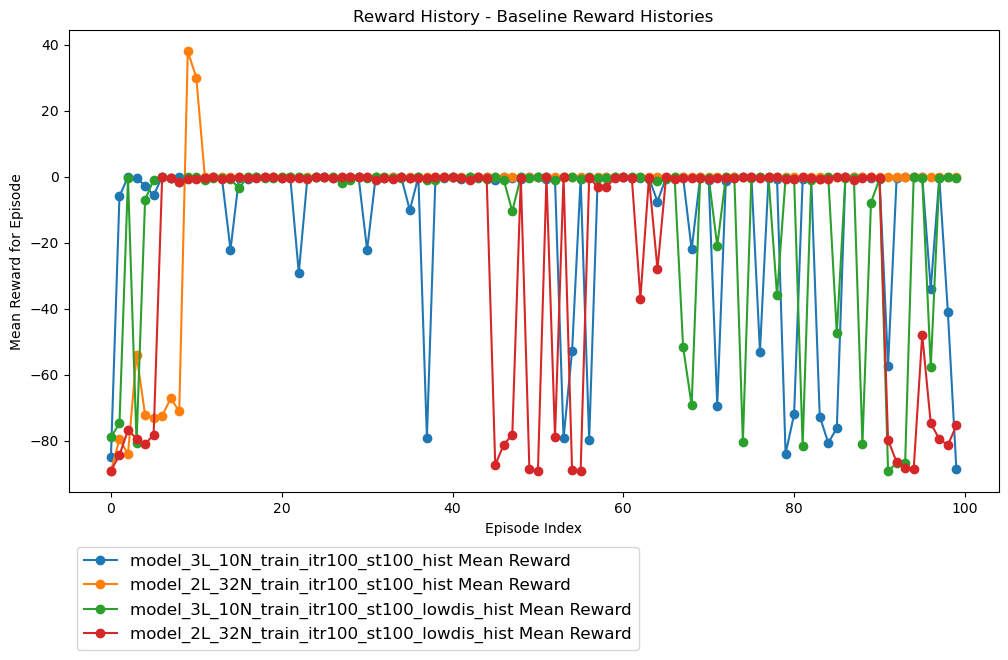

In [ ]:
reward_histories_simple = {}
reward_histories_simple["basic"] = histories
print(histories)
PlotRewardHistory(histories, title="Baseline Reward Histories", save_fig=True)

In [ ]:
for key, value in models.items():
  value.save(f"{key}_init.keras")



In [ ]:


#save histories
with open("init_histories.pkl", "wb") as writer:
    pickle.dump(histories, writer)



In [ ]:
#implementing boltzmann exploration to test effect on models 

trainingConfigs = [TrainingConfig(n_iterations=100, n_max_steps=100, description="itr100_st100", exploration_policy="boltzmann", exp_scale=2),
                   TrainingConfig(n_iterations=100, n_max_steps=100, description="itr100_st100", exploration_policy="boltzmann", exp_scale=2),]
modelConfigs = [ModelConfig(layer_config=[10, 10, 10], activation="elu", description="3L_10N"),
                ModelConfig(layer_config=[32,32], activation="elu", description="2L_32N")]



In [ ]:
#test with boltzmann
boltz_histories, boltz_models = BuildAndTrainMultipleModels(env, trainingConfigs, modelConfigs)

c:\Users\anon\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
iteration  11
iteration  12
iteration  13
iteration  14
iteration  15
iteration  16
iteration  17
iteration  18
iteration  19
iteration  20
iteration  21
iteration  22
iteration  23
iteration  24
iteration  25
iteration  26
iteration  27
iteration  28
iteration  29
iteration  30
iteration  31
iteration  32
iteration  33
iteration  34
iteration  35
iteration  36
iteration  37
iteration  38
iteration  39
iteration  40
iteration  41
iteration  42
iteration  43
iteration  44
iteration  45
iteration  46
iteration  47
iteration  48
iteration  49
iteration  50
iteration  51
iteration  52
iteration  53
iteration  54
iteration  55
iteration  56
iteration  57
iteration  58
iteration  59
iteration  60
iteration  61
iteration  62
iteration  63
iteration  64
iteration  65
iteration  66
iteration  67
iteration  68
iteration  69
iteration  70
iteration  71
it

In [ ]:
for key, value in boltz_histories.items():
    env.render_history(value, True, True, save_path=f"{key}_heatmap_boltzmann.png")

C:\Users\alast\AppData\Local\Temp\ipykernel_10368\3317029550.py:468: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("jet")


Heatmap saved as model_3L_10N_train_itr100_st100_hist_heatmap_boltzmann.png
Heatmap saved as model_2L_32N_train_itr100_st100_hist_heatmap_boltzmann.png


{'model_3L_10N_train_itr100_st100_hist': [<__main__.EpHistory object at 0x000001C927FC7A90>, <__main__.EpHistory object at 0x000001C928C1DF50>, <__main__.EpHistory object at 0x000001C924BE6410>, <__main__.EpHistory object at 0x000001C929E1DF50>, <__main__.EpHistory object at 0x000001C92A82DF50>, <__main__.EpHistory object at 0x000001C92B17DF50>, <__main__.EpHistory object at 0x000001C92B9ADF50>, <__main__.EpHistory object at 0x000001C92C1B5F50>, <__main__.EpHistory object at 0x000001C92C9CDF50>, <__main__.EpHistory object at 0x000001C92A7E8110>, <__main__.EpHistory object at 0x000001C92EB7DF50>, <__main__.EpHistory object at 0x000001C92D290B50>, <__main__.EpHistory object at 0x000001C92FFFDF50>, <__main__.EpHistory object at 0x000001C92F0C8B50>, <__main__.EpHistory object at 0x000001C93111DF50>, <__main__.EpHistory object at 0x000001C932585F50>, <__main__.EpHistory object at 0x000001C93020E390>, <__main__.EpHistory object at 0x000001C9334D5F50>, <__main__.EpHistory object at 0x000001C9

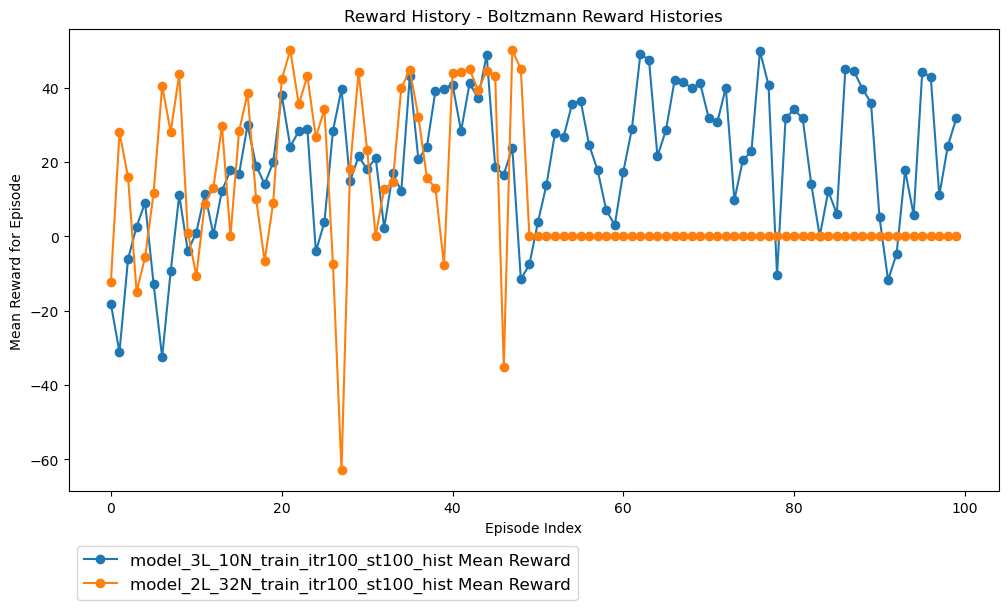

In [ ]:
reward_histories_boltz = {}
reward_histories_boltz["boltz"] = boltz_histories
print(boltz_histories)
PlotRewardHistory(boltz_histories, title="Boltzmann Reward Histories", save_fig=True)

In [ ]:
for key, value in boltz_models.items():
  value.save(f"{key}_boltz.keras")


In [ ]:
#save histories
with open("boltz_histories.pkl", "wb") as writer:
    pickle.dump(boltz_histories, writer)

In [ ]:
#at this point changing reward function to better suit exploration
#old rewards
'''reward_for_step = 0

        #check in bounds
        if(1 <= new_row < self.size - 1 and 1 <= new_col < self.size - 1):
            potential_node = self.map.grid[new_row][new_col]
            #check for wall
            if not potential_node.is_wall:
                self._agent.location = potential_node

            #check for hazard
            elif potential_node.is_hazard:
                self._agent.health = self._agent.health - 2
                reward_for_step = reward_for_step - 2
                
            #just wall
            else:
                reward_for_step = reward_for_step - 1
        else:
            reward_for_step = reward_for_step - 1

        #todo play with reward
        #environment completes if reach target
        terminated = (self._agent.location.row == self._exit_location.row and 
              self._agent.location.col == self._exit_location.col)
        
        truncated = self.current_step >= self.max_steps

        reward_for_step = reward_for_step + 50 if terminated else reward_for_step  # the agent is only reached at the end of the episode'''

In [ ]:
#implementing boltzmann exploration with new reward scheme to test effect on best model

trainingConfigs = [TrainingConfig(n_iterations=100, n_max_steps=100, description="itr100_st100", exploration_policy="boltzmann", exp_scale=2),
                   TrainingConfig(n_iterations=100, n_max_steps=100, description="itr100_st100", exploration_policy="boltzmann", exp_scale=2)]
modelConfigs = [ModelConfig(layer_config=[10, 10, 10], activation="elu", description="3L_10N"),
                ModelConfig(layer_config=[32,32], activation="elu", description="2L_32N")]


In [ ]:
#test new rewards with best boltzmann
boltz_histories_new_reward, boltz_models_new_reward = BuildAndTrainMultipleModels(env, trainingConfigs, modelConfigs)

new model visited:  [(1, 1)]
new model obs - agent: (1, 1)
new model obs - exit: (13, 13)
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
iteration  11
iteration  12
iteration  13
iteration  14
iteration  15
iteration  16
iteration  17
iteration  18
iteration  19
iteration  20
iteration  21
iteration  22
iteration  23
iteration  24
iteration  25
iteration  26
iteration  27
iteration  28
iteration  29
iteration  30
iteration  31
iteration  32
iteration  33
iteration  34
iteration  35
iteration  36
iteration  37
iteration  38
iteration  39
iteration  40
iteration  41
iteration  42
iteration  43
iteration  44
iteration  45
iteration  46
iteration  47
iteration  48
iteration  49
iteration  50
iteration  51
iteration  52
iteration  53
iteration  54
iteration  55
iteration  56
iteration  57
iteration  58
iteration  59
iteration  60
iteration  61
iteration  62
iteration  63
iteration  64
iteration 

In [111]:
for key, value in boltz_histories_new_reward.items():
    env.render_history(value, True, False, save_path=f"{key}_heatmap_boltzmann_new_reward.png")


AttributeError: 'list' object has no attribute 'iteration_histories'

In [24]:
#to load:
with open("boltz_histories_new_reward.pkl", "rb") as writer:
    boltz_histories_new_reward = pickle.load(writer)

{'model_3L_10N_train_itr100_st100_hist': [<__main__.EpHistory object at 0x0000022588561610>, <__main__.EpHistory object at 0x0000022588662B70>, <__main__.EpHistory object at 0x0000022588663620>, <__main__.EpHistory object at 0x0000022588661E80>, <__main__.EpHistory object at 0x0000022588662090>, <__main__.EpHistory object at 0x00000225886622D0>, <__main__.EpHistory object at 0x0000022588662510>, <__main__.EpHistory object at 0x0000022588662750>, <__main__.EpHistory object at 0x0000022588662AB0>, <__main__.EpHistory object at 0x0000022588662D80>, <__main__.EpHistory object at 0x00000225886603E0>, <__main__.EpHistory object at 0x00000225886630E0>, <__main__.EpHistory object at 0x00000225886633B0>, <__main__.EpHistory object at 0x0000022588663560>, <__main__.EpHistory object at 0x0000022588663860>, <__main__.EpHistory object at 0x0000022588663B60>, <__main__.EpHistory object at 0x0000022588663E00>, <__main__.EpHistory object at 0x0000022588FE80E0>, <__main__.EpHistory object at 0x00000225

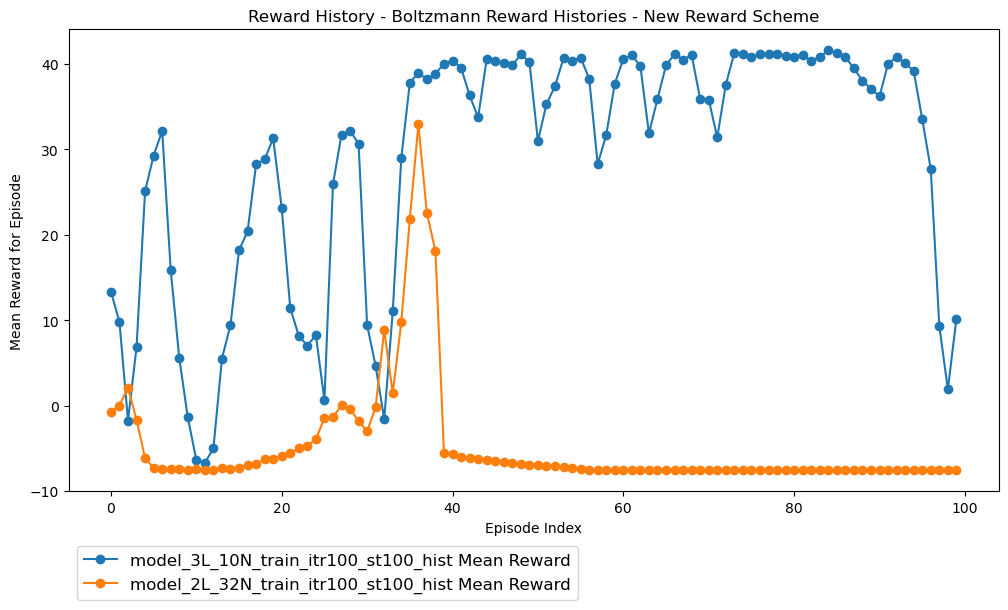

In [29]:
reward_histories_boltz_new_reward = {}
reward_histories_boltz_new_reward["boltz_new"] = boltz_histories_new_reward
print(boltz_histories_new_reward)
PlotRewardHistory(boltz_histories_new_reward, title="Boltzmann Reward Histories - New Reward Scheme", save_fig=True)

In [45]:
reward_histories_boltz_new_reward['boltz_new']['model_2L_32N_train_itr100_st100_hist'][79].agent_locations

[[(1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1),
  (13, 1

In [ ]:
#save histories
with open("boltz_histories_new_reward.pkl", "wb") as writer:
    pickle.dump(boltz_histories_new_reward, writer)

In [ ]:
for key, value in boltz_models_new_reward.items():
  value.save(f"{key}_boltz_new_reward.keras")

at this point reward scheme has been altered for several things:
-above, punishment from touching walls has been lowered from 1 to 0.1
-reward for doors has been changed to (mistakenly the wrong formula) exit_reward - (current step * (100 / max_steps))

this was to encourage more explorationw ith less punishment from touching walls, and to try encourage speed to the door, however the exit reward formula mistakenly punishes the agent for reaching exit in later steps
this has now been changed

reward scheme has been updated to further encourage exploration and speed of reaching exit
-visited tiles are tracked, and if a tile is unvisited, agent recieves small reward of 0.1
-exit reward now = exit_reward - (current_step * (exit_reward / max_steps)) + 1, this means full reward if reached on first step, and ensures atleast a reward of 1 for last step completion
aslong as current_step * (exit_reward / max_steps) > unvisited_reward then optimal paths should be encouraged

new model to be trained with this scheme and then based on results further adjustments or  perhaps observation space changes


In [ ]:
#test render accuracy
#test_hist = [[EpHistory([(1, 1), (1, 2), (2, 2), (2, 3), (3, 3), (13, 13)], (13, 13), [0, 0, 0, 0, 0, 0])]]

#env.render_history(test_hist, True, False, save_path=f"test")

C:\Users\anon\AppData\Local\Temp\ipykernel_34380\775628353.py:510: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("jet")


In [ ]:
#debug testing to see accuracy of movement
#debug_action_list_input = [0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0 ,0 ,0, 3, 3, 0, 0, 1]
#trainingConfigs = [TrainingConfig(n_iterations=10, n_max_steps=100, description="debug", exploration_policy="debug_queue", exp_scale=2, debug_action_list=debug_action_list_input)]
#modelConfigs = [ModelConfig(layer_config=[10, 10, 10], activation="elu", description="3L_10N")]

#boltz_histories_debug, boltz_models_debug = BuildAndTrainMultipleModels(env, trainingConfigs, modelConfigs)



c:\Users\anon\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


new model visited:  [(1, 1)]
new model obs - agent: (1, 1)
new model obs - exit: (13, 13)
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
model_3L_10N_train_debug built and trained.


In [ ]:
#print(boltz_histories_debug)

#boltz less decay heatmaps and history
#for key, value in boltz_histories_debug.items():
    #env.render_history(value, False, False, save_path=f"{key}_heatmap_debug.png")



{'model_3L_10N_train_debug_hist': <__main__.TrainingHistory object at 0x00000225919F1940>}


KeyboardInterrupt: 

In [ ]:
#decay of boltzmann reduced
trainingConfigs = [TrainingConfig(n_iterations=100, n_max_steps=100, description="itr100_st100", exploration_policy="boltzmann", exp_scale=2),
                   TrainingConfig(n_iterations=100, n_max_steps=100, description="itr100_st100_dupe_test", exploration_policy="boltzmann", exp_scale=2),
                   TrainingConfig(n_iterations=100, n_max_steps=100, description="itr100_st100", exploration_policy="boltzmann", exp_scale=2)]
modelConfigs = [ModelConfig(layer_config=[10, 10, 10], activation="elu", description="3L_10N"),
                ModelConfig(layer_config=[10, 10, 10], activation="elu", description="3L_10N"),
                ModelConfig(layer_config=[32,32], activation="elu", description="2L_32N")]

In [119]:
#train less decay boltzmann
boltz_histories_less_decay, boltz_models_less_decay = BuildAndTrainMultipleModels(env, trainingConfigs, modelConfigs)

c:\Users\anon\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


new model visited:  [(1, 1)]
new model obs - agent: (1, 1)
new model obs - exit: (13, 13)
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
iteration  11
iteration  12
iteration  13
iteration  14
iteration  15
iteration  16
iteration  17
iteration  18
iteration  19
iteration  20
iteration  21
iteration  22
iteration  23
iteration  24
iteration  25
iteration  26
iteration  27
iteration  28
iteration  29
iteration  30
iteration  31
iteration  32
iteration  33
iteration  34
iteration  35
iteration  36
iteration  37
iteration  38
iteration  39
iteration  40
iteration  41
iteration  42
iteration  43
iteration  44
iteration  45
iteration  46
iteration  47
iteration  48
iteration  49
iteration  50
iteration  51
iteration  52
iteration  53
iteration  54
iteration  55
iteration  56
iteration  57
iteration  58
iteration  59
iteration  60
iteration  61
iteration  62
iteration  63
iteration  64
iteration 

In [127]:
#boltz less decay heatmaps and history
for key, value in boltz_histories_less_decay.items():
    env.render_history(value, True, True, save_path=f"{key}_heatmap_boltzmann_less_decay.png")

C:\Users\anon\AppData\Local\Temp\ipykernel_34380\865695804.py:510: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("jet")


Heatmap saved as model_3L_10N_train_itr100_st100_hist_heatmap_boltzmann_less_decay.png
Heatmap saved as model_3L_10N_train_itr100_st100_dupe_test_hist_heatmap_boltzmann_less_decay.png
Heatmap saved as model_2L_32N_train_itr100_st100_hist_heatmap_boltzmann_less_decay.png


{'model_3L_10N_train_itr100_st100_hist': <__main__.TrainingHistory object at 0x0000022588FE9DF0>, 'model_3L_10N_train_itr100_st100_dupe_test_hist': <__main__.TrainingHistory object at 0x00000225919B8A40>, 'model_2L_32N_train_itr100_st100_hist': <__main__.TrainingHistory object at 0x00000225919C9550>}


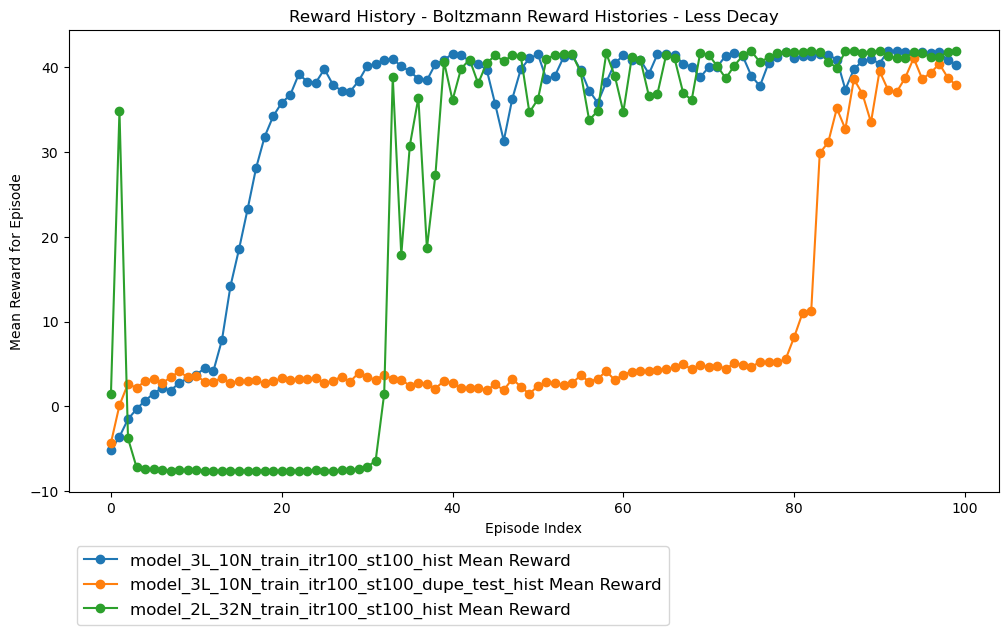

In [137]:
#boltz less decay plot reward history
reward_histories_boltz_less_decay = {}
reward_histories_boltz_less_decay["boltz_less_decay"] = boltz_histories_less_decay
print(boltz_histories_less_decay)
PlotRewardHistory(boltz_histories_less_decay, title="Boltzmann Reward Histories - Less Decay", save_fig=True)

In [128]:
#save histories less decay
with open("boltz_histories_less_decay.pkl", "wb") as writer:
    pickle.dump(boltz_histories_less_decay, writer)

In [130]:
#save models
for key, value in boltz_models_less_decay.items():
  value.save(f"{key}_boltz_less_decay.keras")

decay of boltzmann exploration helped continue learning process, still strange phenomenon of getting cosy in a corner, especially on the 2l_32n models.
new reward scheme has improved behaviour

next steps is to increase the observation space, decrease learning rate, run longer tests

In [ ]:
#train longer lower learning rate boltzmann
trainingConfigs = [TrainingConfig(n_iterations=200, n_max_steps=100, description="itr200_st100", exploration_policy="boltzmann", exp_scale=2),
                   TrainingConfig(n_iterations=200, n_max_steps=100, description="itr200_st100", exploration_policy="boltzmann", exp_scale=2),
                   TrainingConfig(n_iterations=200, n_max_steps=100, description="itr200_st100", exploration_policy="boltzmann", exp_scale=2),
                   TrainingConfig(n_iterations=200, n_max_steps=100, description="itr200_st100_lower_learn", exploration_policy="boltzmann", exp_scale=2, learning_rate=0.005),
                   TrainingConfig(n_iterations=200, n_max_steps=100, description="itr200_st100_lower_learn", exploration_policy="boltzmann", exp_scale=2, learning_rate=0.005),
                   TrainingConfig(n_iterations=200, n_max_steps=100, description="itr200_st100_lower_learn", exploration_policy="boltzmann", exp_scale=2, learning_rate=0.005)]
modelConfigs = [ModelConfig(layer_config=[5, 5, 5], activation="elu", description="3L_5N"),
                ModelConfig(layer_config=[10, 10, 10], activation="elu", description="3L_10N"),
                ModelConfig(layer_config=[15, 15, 15], activation="elu", description="3L_15N"),
                ModelConfig(layer_config=[5, 5, 5], activation="elu", description="3L_5N"),
                ModelConfig(layer_config=[10, 10, 10], activation="elu", description="3L_10N"),
                ModelConfig(layer_config=[15, 15, 15], activation="elu", description="3L_15N")]

In [145]:
#train longer lower learning rate boltzmann
env.reset()
boltz_histories_long_lower_learn, boltz_models_long_lower_learn = BuildAndTrainMultipleModels(env, trainingConfigs, modelConfigs)

new model visited:  [(1, 1)]
new model obs - agent: (1, 1)
new model obs - exit: (13, 13)
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
iteration  11
iteration  12
iteration  13
iteration  14
iteration  15
iteration  16
iteration  17
iteration  18
iteration  19
iteration  20
iteration  21
iteration  22
iteration  23
iteration  24
iteration  25
iteration  26
iteration  27
iteration  28
iteration  29
iteration  30
iteration  31
iteration  32
iteration  33
iteration  34
iteration  35
iteration  36
iteration  37
iteration  38
iteration  39
iteration  40
iteration  41
iteration  42
iteration  43
iteration  44
iteration  45
iteration  46
iteration  47
iteration  48
iteration  49
iteration  50
iteration  51
iteration  52
iteration  53
iteration  54
iteration  55
iteration  56
iteration  57
iteration  58
iteration  59
iteration  60
iteration  61
iteration  62
iteration  63
iteration  64
iteration 

In [151]:
#longer lower learning rate boltzmann
for key, value in boltz_histories_long_lower_learn.items():
    env.render_history(value, True, True, save_path=f"{key}_heatmap_boltzmann_long_lower_learn.png")

C:\Users\anon\AppData\Local\Temp\ipykernel_34380\865695804.py:510: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("jet")


Heatmap saved as model_3L_5N_train_itr200_st100_hist_heatmap_boltzmann_long_lower_learn.png
Heatmap saved as model_3L_10N_train_itr200_st100_hist_heatmap_boltzmann_long_lower_learn.png
Heatmap saved as model_3L_15N_train_itr200_st100_hist_heatmap_boltzmann_long_lower_learn.png
Heatmap saved as model_3L_5N_train_itr200_st100_lower_learn_hist_heatmap_boltzmann_long_lower_learn.png
Heatmap saved as model_3L_10N_train_itr200_st100_lower_learn_hist_heatmap_boltzmann_long_lower_learn.png
Heatmap saved as model_3L_15N_train_itr200_st100_lower_learn_hist_heatmap_boltzmann_long_lower_learn.png


{'model_3L_5N_train_itr200_st100_hist': <__main__.TrainingHistory object at 0x000001C298C51A30>, 'model_3L_10N_train_itr200_st100_hist': <__main__.TrainingHistory object at 0x000001C2997C6870>, 'model_3L_15N_train_itr200_st100_hist': <__main__.TrainingHistory object at 0x000001C29A1119A0>, 'model_3L_5N_train_itr200_st100_lower_learn_hist': <__main__.TrainingHistory object at 0x000001C29AAC0AD0>, 'model_3L_10N_train_itr200_st100_lower_learn_hist': <__main__.TrainingHistory object at 0x000001C29B4C7BC0>, 'model_3L_15N_train_itr200_st100_lower_learn_hist': <__main__.TrainingHistory object at 0x000001C29BE92CF0>}


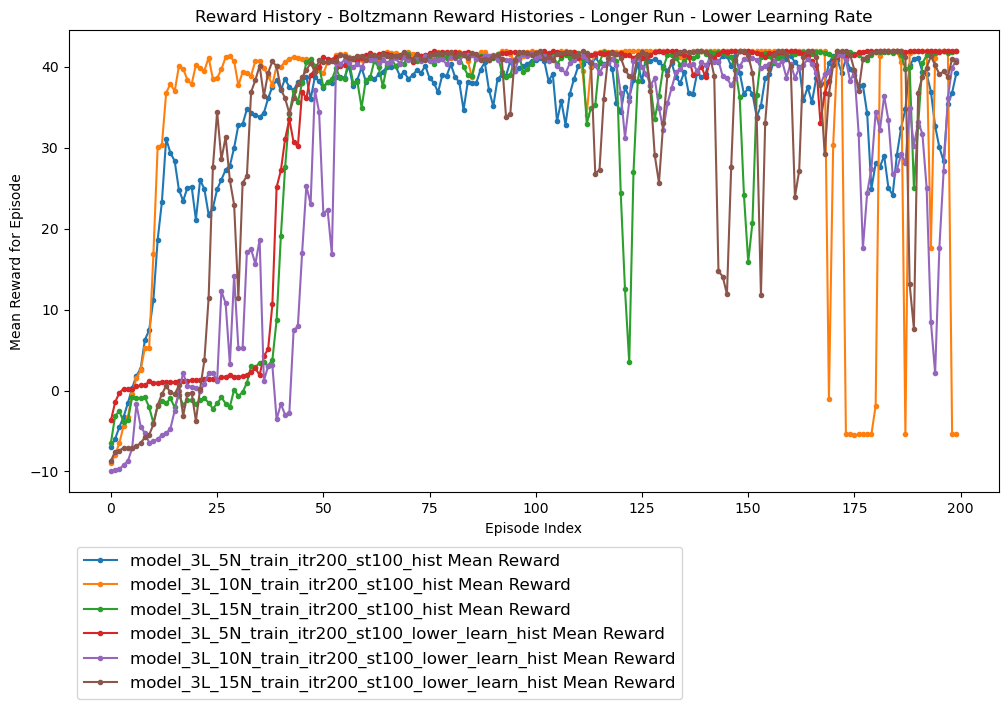

In [29]:
#boltz less decay plot reward history
print(boltz_histories_long_lower_learn)
PlotRewardHistory(boltz_histories_long_lower_learn, marker=".", title="Boltzmann Reward Histories - Longer Run - Lower Learning Rate", save_fig=True)

interestingly, red most stable, least complex model and lower learning rate, perhaps other models are overfitting and leading to forgetting learnt behaviours
blue also more stable than others but higher learn rate than rate

also after 100 episodes performance starts to dip interestingly, starting to forget as it trends towards greedy bad behaviours may enter a perpetual cycle without some sort of excperience replay to keep good memories in play, or a secondary model to guide decisionsand maintain stability

In [148]:
#save histories less decay
with open("boltz_histories_long_lower_learn.pkl", "wb") as writer:
    pickle.dump(boltz_histories_long_lower_learn, writer)

In [149]:
#save models
for key, value in boltz_models_long_lower_learn.items():
  value.save(f"{key}_boltz_long_lower_learn.keras")

In [27]:
with open("boltz_histories_long_lower_learn.pkl", "rb") as writer:
    boltz_histories_long_lower_learn = pickle.load(writer)

In [62]:
#train new mode style - complete map state as observation, new bigger model shapes
trainingConfigs = [TrainingConfig(n_iterations=200, n_max_steps=100, description="boltz_low_learn", exploration_policy="boltzmann", exp_scale=2, learning_rate=0.005),
                   TrainingConfig(n_iterations=200, n_max_steps=100, description="boltz_low_learn", exploration_policy="boltzmann", exp_scale=2, learning_rate=0.005),
                   TrainingConfig(n_iterations=200, n_max_steps=100, description="boltz_low_learn", exploration_policy="boltzmann", exp_scale=2, learning_rate=0.005)]
modelConfigs = [ModelConfig(layer_config=[156, 156, 156], activation="elu", description="3L_156N", n_inputs=229),
                ModelConfig(layer_config=[156, 156], activation="elu", description="2L_156N", n_inputs=229),
                ModelConfig(layer_config=[156], activation="elu", description="1L_156N", n_inputs=229)]

In [63]:
#train new mode style - complete map state
env.reset()
map_obs_histories, map_obs_models = BuildAndTrainMultipleModels(env, trainingConfigs, modelConfigs)

c:\Users\anon\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


new model visited:  [(1, 1)]
new model obs - agent: (1, 1)
new model obs - exit: (13, 13)
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
iteration  11
iteration  12
iteration  13
iteration  14
iteration  15
iteration  16
iteration  17
iteration  18
iteration  19
iteration  20
iteration  21
iteration  22
iteration  23
iteration  24
iteration  25
iteration  26
iteration  27
iteration  28
iteration  29
iteration  30
iteration  31
iteration  32
iteration  33
iteration  34
iteration  35
iteration  36
iteration  37
iteration  38
iteration  39
iteration  40
iteration  41
iteration  42
iteration  43
iteration  44
iteration  45
iteration  46
iteration  47
iteration  48
iteration  49
iteration  50
iteration  51
iteration  52
iteration  53
iteration  54
iteration  55
iteration  56
iteration  57
iteration  58
iteration  59
iteration  60
iteration  61
iteration  62
iteration  63
iteration  64
iteration 

In [64]:
#new mode style - complete map state
for key, value in map_obs_histories.items():
    env.render_history(value, True, True, save_path=f"{key}_heatmap_map_obs.png")

C:\Users\anon\AppData\Local\Temp\ipykernel_30488\1015719481.py:526: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("jet")


Heatmap saved as model_3L_156N_train_boltz_low_learn_hist_heatmap_map_obs.png
Heatmap saved as model_2L_156N_train_boltz_low_learn_hist_heatmap_map_obs.png
Heatmap saved as model_1L_156N_train_boltz_low_learn_hist_heatmap_map_obs.png


{'model_3L_156N_train_boltz_low_learn_hist': <__main__.TrainingHistory object at 0x000001C2C4147A70>, 'model_2L_156N_train_boltz_low_learn_hist': <__main__.TrainingHistory object at 0x000001C2CFFF50D0>, 'model_1L_156N_train_boltz_low_learn_hist': <__main__.TrainingHistory object at 0x000001C2A438BF50>}


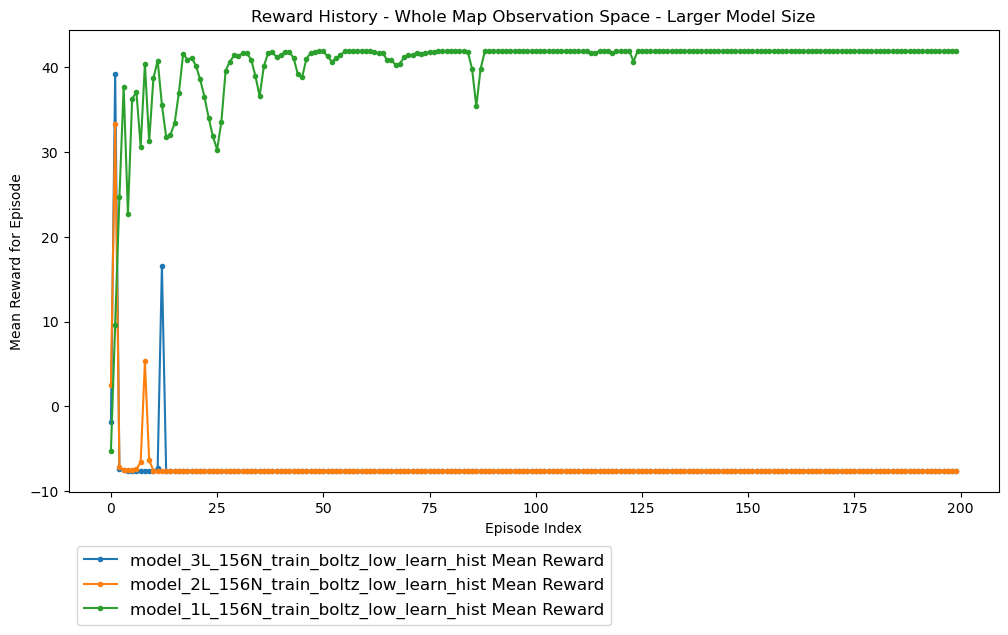

In [65]:
#boltz less decay plot reward history
print(map_obs_histories)
PlotRewardHistory(map_obs_histories, marker=".", title="Whole Map Observation Space - Larger Model Size", save_fig=True)

In [ ]:
#save histories less decay complete map
with open("map_obs_histories.pkl", "wb") as writer:
    pickle.dump(map_obs_histories, writer)

In [ ]:
#save models comp map
for key, value in map_obs_models.items():
  value.save(f"{key}_map_obs.keras")

In [24]:
#more attempts with single layer larger models
#train new mode style - complete map state as observation, new bigger model shapes
trainingConfigs = [TrainingConfig(n_iterations=200, n_max_steps=100, description="boltz_low_learn", exploration_policy="boltzmann", exp_scale=2, learning_rate=0.005),
                   TrainingConfig(n_iterations=200, n_max_steps=100, description="boltz_low_learn", exploration_policy="boltzmann", exp_scale=2, learning_rate=0.005),
                   TrainingConfig(n_iterations=200, n_max_steps=100, description="boltz_low_learn", exploration_policy="boltzmann", exp_scale=2, learning_rate=0.005)]
modelConfigs = [ModelConfig(layer_config=[50], activation="elu", description="1L_50N", n_inputs=229),
                ModelConfig(layer_config=[100], activation="elu", description="1L_100N", n_inputs=229),
                ModelConfig(layer_config=[150], activation="elu", description="1L_150N", n_inputs=229)]

In [25]:
#train complete map state
#more attempts with single layer larger models
env.reset()
map_obs_sgl_layer_histories, map_obs_sgl_layer_models = BuildAndTrainMultipleModels(env, trainingConfigs, modelConfigs)

c:\Users\anon\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


new model visited:  [(1, 1)]
new model obs - agent: (1, 1)
new model obs - exit: (13, 13)
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
iteration  11
iteration  12
iteration  13
iteration  14
iteration  15
iteration  16
iteration  17
iteration  18
iteration  19
iteration  20
iteration  21
iteration  22
iteration  23
iteration  24
iteration  25
iteration  26
iteration  27
iteration  28
iteration  29
iteration  30
iteration  31
iteration  32
iteration  33
iteration  34
iteration  35
iteration  36
iteration  37
iteration  38
iteration  39
iteration  40
iteration  41
iteration  42
iteration  43
iteration  44
iteration  45
iteration  46
iteration  47
iteration  48
iteration  49
iteration  50
iteration  51
iteration  52
iteration  53
iteration  54
iteration  55
iteration  56
iteration  57
iteration  58
iteration  59
iteration  60
iteration  61
iteration  62
iteration  63
iteration  64
iteration 

In [26]:
#new mode style - complete map state
#more attempts with single layer larger models
for key, value in map_obs_sgl_layer_histories.items():
    env.render_history(value, True, True, save_path=f"{key}_heatmap_map_obs_sgl_layer.png")

C:\Users\anon\AppData\Local\Temp\ipykernel_35056\2070018717.py:528: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("jet")


Heatmap saved as model_1L_50N_train_boltz_low_learn_hist_heatmap_map_obs_sgl_layer.png
Heatmap saved as model_1L_100N_train_boltz_low_learn_hist_heatmap_map_obs_sgl_layer.png
Heatmap saved as model_1L_150N_train_boltz_low_learn_hist_heatmap_map_obs_sgl_layer.png


{'model_1L_50N_train_boltz_low_learn_hist': <__main__.TrainingHistory object at 0x0000020D21950830>, 'model_1L_100N_train_boltz_low_learn_hist': <__main__.TrainingHistory object at 0x0000020D33506B10>, 'model_1L_150N_train_boltz_low_learn_hist': <__main__.TrainingHistory object at 0x0000020D3358B860>}


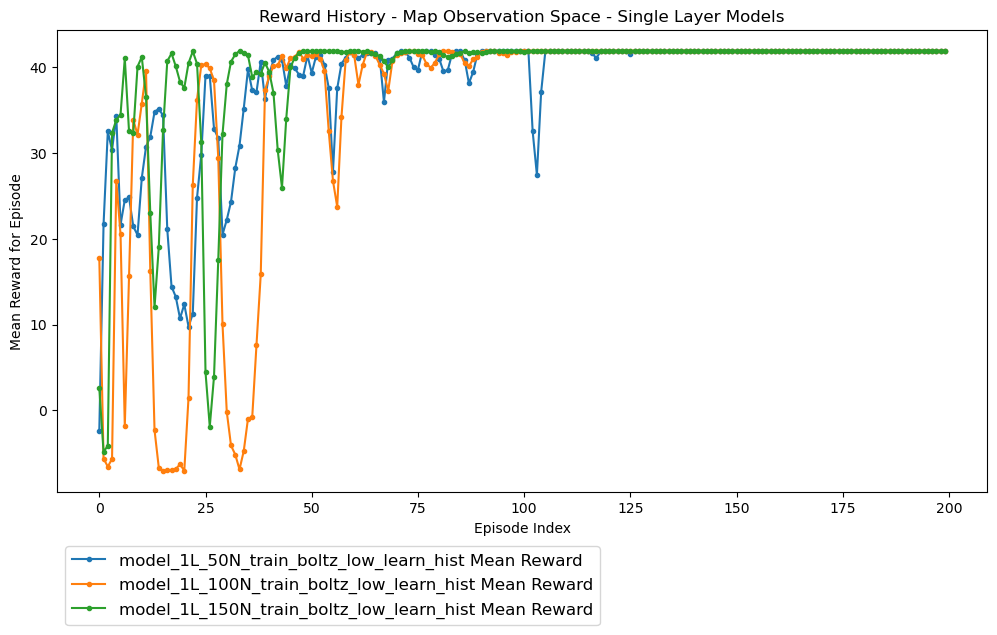

In [27]:
#boltz less decay plot reward history
#more attempts with single layer larger models
print(map_obs_sgl_layer_histories)
PlotRewardHistory(map_obs_sgl_layer_histories, marker=".", title="Map Observation Space - Single Layer Models", save_fig=True)

In [28]:
#save histories less decay complete map
#more attempts with single layer larger models
with open("map_obs_sgl_layer_histories.pkl", "wb") as writer:
    pickle.dump(map_obs_sgl_layer_histories, writer)

In [29]:
#save models comp map more attempts
for key, value in map_obs_sgl_layer_models.items():
  value.save(f"{key}_map_obs_sgl_layer.keras")

# V3 Env Make

In [38]:
env = gym.make("GridWorld-v0", max_episode_steps=100, obs_mode="v3",
               init_map_options = MapOptions(cycle_bias=0.8, cluster_strength=0.5, cluster_type="distance", is_base_map=False, seed=1, hazard_level=5)).unwrapped

env.render()
#observation, info = env.reset()

#print("Initial Observation:", observation)

drawMap(env.get_map())

env.get_obs()
            ##tile info for NN input
            # 0 empty
            # 1 wall
            # 2 key
            # 3 exit
            # 4 player
            # 5 hazard
            # 6 enemy

Cycle bias, num edges, num cycles:  (0.8, 0, 53.0)
map before cycles
###############
#   #         #
##X # # ### ###
#     #   # # #
####### # X # #
#   #   # #   #
### # ##### # #
# #     # # # #
# ### # # #X# #
#   # #     # #
# # ### ####X##
# # # # #     #
### # X # # ###
#         #   #
###############
###############
#             #
# X     # #  ##
#             #
#     #   X   #
#             #
# S   #       #
#             #
#     #    X  #
#     #     # #
#     #    DX #
#     #       #
#   # X #   ###
#         #   #
###############


{'agent': <__main__.Node at 0x2059fa09f10>,
 'target': <__main__.Node at 0x205a1a39550>,
 'tile_info': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 0, 5, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 5, 0, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 0, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 5, 0, 0, 1],
  [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
  [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 5, 0, 1],
  [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
  [1, 0, 0, 0, 1, 0, 5, 0, 1, 0, 0, 0, 1, 1, 1],
  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
 'agent_health': 10}

At this point - env and map making has been updated to include full door and player spawn support, and environment spawning new levels and not using a base barebones one
the environment also features a wide obs space including the whole grid with int info for different entities

the model is now taking in a large amount of inputs, to a single hidden layer of 150ish neurons, and exhibiting relative stability within a basic bare level

now with the level generation pipeline, this will be initial tests at how the models perform in a more complicated level

now adding in agent health to observation space as hazards are now present

In [28]:
#proper level gen with hazards now, different single layer models
trainingConfigs = [TrainingConfig(n_iterations=200, n_max_steps=100, description="proper_map_BLL_lower_learn", exploration_policy="boltzmann", exp_scale=2, learning_rate=0.002),
                   TrainingConfig(n_iterations=200, n_max_steps=100, description="proper_map_BLL", exploration_policy="boltzmann", exp_scale=2, learning_rate=0.005),
                   TrainingConfig(n_iterations=200, n_max_steps=100, description="proper_map_BLL_lower_learn_high_exp", exploration_policy="boltzmann", exp_scale=3, learning_rate=0.002),
                   TrainingConfig(n_iterations=200, n_max_steps=100, description="proper_map_BLL_high_exp", exploration_policy="boltzmann", exp_scale=3, learning_rate=0.005),
                   TrainingConfig(n_iterations=200, n_max_steps=100, description="proper_map_BLL_lower_learn", exploration_policy="boltzmann", exp_scale=2, learning_rate=0.002),
                   TrainingConfig(n_iterations=200, n_max_steps=100, description="proper_map_BLL", exploration_policy="boltzmann", exp_scale=2, learning_rate=0.005)]
modelConfigs = [ModelConfig(layer_config=[50], activation="elu", description="1L_50N", n_inputs=230),
                ModelConfig(layer_config=[50], activation="elu", description="1L_50N", n_inputs=230),
                ModelConfig(layer_config=[50, 50], activation="elu", description="2L_50N", n_inputs=230),
                ModelConfig(layer_config=[50, 50], activation="elu", description="2L_50N", n_inputs=230),
                ModelConfig(layer_config=[128], activation="elu", description="1L_128N", n_inputs=230),
                ModelConfig(layer_config=[128], activation="elu", description="1L_128N", n_inputs=230)]

In [29]:
#train complete map state
#more attempts with single layer larger models
env.reset()
proper_map_test_histories, proper_map_test_models = BuildAndTrainMultipleModels(env, trainingConfigs, modelConfigs)

new model visited:  [(2, 6)]
new model obs - agent: (2, 6)
new model obs - exit: (11, 10)
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
iteration  11
iteration  12
iteration  13
iteration  14
iteration  15
iteration  16
iteration  17
iteration  18
iteration  19
iteration  20
iteration  21
iteration  22
iteration  23
iteration  24
iteration  25
iteration  26
iteration  27
iteration  28
iteration  29
iteration  30
iteration  31
iteration  32
iteration  33
iteration  34
iteration  35
iteration  36
iteration  37
iteration  38
iteration  39
iteration  40
iteration  41
iteration  42
iteration  43
iteration  44
iteration  45
iteration  46
iteration  47
iteration  48
iteration  49
iteration  50
iteration  51
iteration  52
iteration  53
iteration  54
iteration  55
iteration  56
iteration  57
iteration  58
iteration  59
iteration  60
iteration  61
iteration  62
iteration  63
iteration  64
iteration 

In [39]:
#proper level gen with hazards now, different single layer models
for key, value in proper_map_test_histories.items():
    env.render_history(value, True, True, save_path=f"{key}_heatmap_proper_map_test.png")

C:\Users\anon\AppData\Local\Temp\ipykernel_12268\1420220652.py:523: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("jet")


Heatmap saved as model_1L_50N_train_proper_map_BLL_lower_learn_hist_heatmap_proper_map_test.png
Heatmap saved as model_1L_50N_train_proper_map_BLL_hist_heatmap_proper_map_test.png
Heatmap saved as model_2L_50N_train_proper_map_BLL_lower_learn_high_exp_hist_heatmap_proper_map_test.png
Heatmap saved as model_2L_50N_train_proper_map_BLL_high_exp_hist_heatmap_proper_map_test.png
Heatmap saved as model_1L_128N_train_proper_map_BLL_lower_learn_hist_heatmap_proper_map_test.png
Heatmap saved as model_1L_128N_train_proper_map_BLL_hist_heatmap_proper_map_test.png


{'model_1L_50N_train_proper_map_BLL_lower_learn_hist': <__main__.TrainingHistory object at 0x00000205EEB5AD50>, 'model_1L_50N_train_proper_map_BLL_hist': <__main__.TrainingHistory object at 0x00000205EEB59550>, 'model_2L_50N_train_proper_map_BLL_lower_learn_high_exp_hist': <__main__.TrainingHistory object at 0x00000205ED0288C0>, 'model_2L_50N_train_proper_map_BLL_high_exp_hist': <__main__.TrainingHistory object at 0x00000205FE1BCC20>, 'model_1L_128N_train_proper_map_BLL_lower_learn_hist': <__main__.TrainingHistory object at 0x00000205F924A450>, 'model_1L_128N_train_proper_map_BLL_hist': <__main__.TrainingHistory object at 0x00000205FF2333B0>}


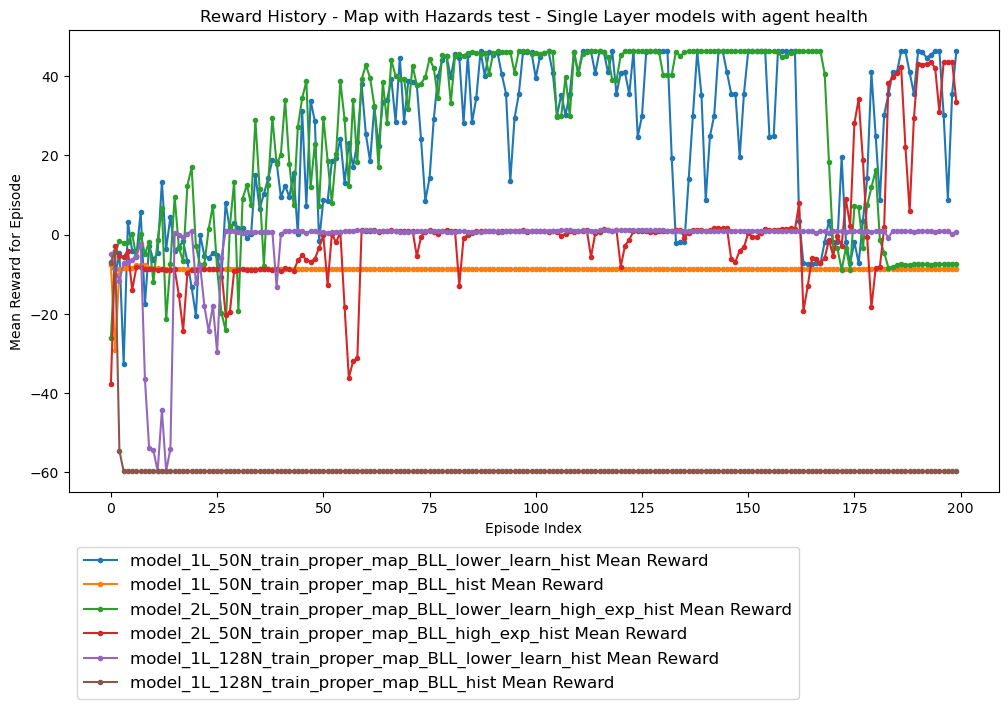

In [31]:
#boltz less decay plot reward history
#more attempts with single layer larger models
print(proper_map_test_histories)
PlotRewardHistory(proper_map_test_histories, marker=".", title="Map with Hazards test - Single Layer models with agent health", save_fig=True)

In [32]:
#save histories proper level gen with hazards now, different single layer models
#proper level gen with hazards now, different single layer models
with open("proper_map_test_histories.pkl", "wb") as writer:
    pickle.dump(proper_map_test_histories, writer)

In [33]:
#proper level gen with hazards now, different single layer models
for key, value in proper_map_test_models.items():
  value.save(f"{key}_proper_map_test.keras")

the results seem to indicate still that less complex NN's are better, and a lower learning rate and higher rates of exploration improve performance
the worst performers are consistently the most complex networks

i am beginning to think about the fact that encoding the grid state as integers doesn't quite make sense mathematically - it implies ordering, and there isnt a mathematical ordering or relationship between wall being 1 or player being 3, etc
if they are more categorical then categorical encoding like one hot makes more sense to truly encode state meaning

# V4 Env Make

In [24]:
env = gym.make("GridWorld-v0", max_episode_steps=100, obs_mode="v4",
               init_map_options = MapOptions(cycle_bias=0.8, cluster_strength=0.5, cluster_type="distance", is_base_map=False, seed=1, hazard_level=5)).unwrapped


drawMap(env.get_map())

print(env.map)

env.get_obs()


Cycle bias, num edges, num cycles:  (0.8, 0, 53.0)
map before cycles
###############
#   #         #
##X # # ### ###
#     #   # # #
####### # X # #
#   #   # #   #
### # ##### # #
# #     # # # #
# ### # # #X# #
#   # #     # #
# # ### ####X##
# # # # #     #
### # X # # ###
#         #   #
###############
###############
#             #
# X     # #  ##
#             #
#     #   X   #
#             #
# S   #       #
#             #
#     #    X  #
#     #     # #
#     #    DX #
#     #       #
#   # X #   ###
#         #   #
###############


{'agent': <__main__.Node at 0x1f5a0a72a80>,
 'target': <__main__.Node at 0x1f5a0a73c80>,
 'tile_info': array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 1., 1., ..., 1., 1., 0.],
         [0., 1., 0., ..., 1., 0., 0.],
         ...,
         [0., 1., 1., ..., 0., 0., 0.],
         [0., 1., 1., ..., 1., 1., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 0., 0., ..., 0., 0., 1.],
         [1., 0., 0., ..., 0., 1., 1.],
         ...,
         [1., 0., 0., ..., 1., 1., 1.],
         [1., 0., 0., ..., 0., 0., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0

In [37]:
#now proper map with one hot encoding for channels of entities
trainingConfigs = [TrainingConfig(n_iterations=400, n_max_steps=100, description="one_hot_proper_map_exp4", exploration_policy="boltzmann", exp_scale=4, learning_rate=0.001),
                   TrainingConfig(n_iterations=400, n_max_steps=100, description="one_hot_proper_map_exp4", exploration_policy="boltzmann", exp_scale=4, learning_rate=0.001),
                   TrainingConfig(n_iterations=400, n_max_steps=100, description="one_hot_proper_map_exp4", exploration_policy="boltzmann", exp_scale=4, learning_rate=0.001),
                   TrainingConfig(n_iterations=400, n_max_steps=100, description="one_hot_proper_map_exp4", exploration_policy="boltzmann", exp_scale=4, learning_rate=0.001),
                   TrainingConfig(n_iterations=400, n_max_steps=100, description="one_hot_proper_map_exp4", exploration_policy="boltzmann", exp_scale=4, learning_rate=0.001),
                   TrainingConfig(n_iterations=400, n_max_steps=100, description="one_hot_proper_map_exp4", exploration_policy="boltzmann", exp_scale=4, learning_rate=0.001),
                   TrainingConfig(n_iterations=400, n_max_steps=100, description="one_hot_proper_map_exp4", exploration_policy="boltzmann", exp_scale=4, learning_rate=0.001),
                   TrainingConfig(n_iterations=400, n_max_steps=100, description="one_hot_proper_map_exp4", exploration_policy="boltzmann", exp_scale=4, learning_rate=0.001)]
modelConfigs = [ModelConfig(layer_config=[32], activation="elu", description="1L_32N", n_inputs=1805),
                ModelConfig(layer_config=[64], activation="elu", description="1L_64N", n_inputs=1805),
                ModelConfig(layer_config=[64, 32], activation="elu", description="2L_62_32N", n_inputs=1805),
                ModelConfig(layer_config=[64, 64], activation="elu", description="2L_64N", n_inputs=1805),
                ModelConfig(layer_config=[128], activation="elu", description="1L_128N", n_inputs=1805),
                ModelConfig(layer_config=[256], activation="elu", description="1L_256N", n_inputs=1805),
                ModelConfig(layer_config=[128, 64], activation="elu", description="2L_128_64N", n_inputs=1805),
                ModelConfig(layer_config=[256, 128], activation="elu", description="2L_256_128N", n_inputs=1805)]

In [38]:
#train complete map state with one hot encoding
env.reset()
one_hot_map_test_histories, one_hot_map_test_models = BuildAndTrainMultipleModels(env, trainingConfigs, modelConfigs)

new model visited:  [(2, 6)]
new model obs - agent: (2, 6)
new model obs - exit: (11, 10)
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
iteration  11
iteration  12
iteration  13
iteration  14
iteration  15
iteration  16
iteration  17
iteration  18
iteration  19
iteration  20
iteration  21
iteration  22
iteration  23
iteration  24
iteration  25
iteration  26
iteration  27
iteration  28
iteration  29
iteration  30
iteration  31
iteration  32
iteration  33
iteration  34
iteration  35
iteration  36
iteration  37
iteration  38
iteration  39
iteration  40
iteration  41
iteration  42
iteration  43
iteration  44
iteration  45
iteration  46
iteration  47
iteration  48
iteration  49
iteration  50
iteration  51
iteration  52
iteration  53
iteration  54
iteration  55
iteration  56
iteration  57
iteration  58
iteration  59
iteration  60
iteration  61
iteration  62
iteration  63
iteration  64
iteration 

In [39]:
#proper level gen with hazards now, one hot encoding
for key, value in one_hot_map_test_histories.items():
    env.render_history(value, True, True, save_path=f"{key}_heatmap_one_hot_map_test.png")

C:\Users\anon\AppData\Local\Temp\ipykernel_7744\3585437410.py:563: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("jet")


Heatmap saved as model_1L_32N_train_one_hot_proper_map_exp4_hist_heatmap_one_hot_map_test.png
Heatmap saved as model_1L_64N_train_one_hot_proper_map_exp4_hist_heatmap_one_hot_map_test.png
Heatmap saved as model_2L_62_32N_train_one_hot_proper_map_exp4_hist_heatmap_one_hot_map_test.png
Heatmap saved as model_2L_64N_train_one_hot_proper_map_exp4_hist_heatmap_one_hot_map_test.png
Heatmap saved as model_1L_128N_train_one_hot_proper_map_exp4_hist_heatmap_one_hot_map_test.png
Heatmap saved as model_1L_256N_train_one_hot_proper_map_exp4_hist_heatmap_one_hot_map_test.png
Heatmap saved as model_2L_128_64N_train_one_hot_proper_map_exp4_hist_heatmap_one_hot_map_test.png
Heatmap saved as model_2L_256_128N_train_one_hot_proper_map_exp4_hist_heatmap_one_hot_map_test.png


{'model_1L_32N_train_one_hot_proper_map_exp4_hist': <__main__.TrainingHistory object at 0x000001F887C0A7B0>, 'model_1L_64N_train_one_hot_proper_map_exp4_hist': <__main__.TrainingHistory object at 0x000001F5A08EE990>, 'model_2L_62_32N_train_one_hot_proper_map_exp4_hist': <__main__.TrainingHistory object at 0x000001F875075E80>, 'model_2L_64N_train_one_hot_proper_map_exp4_hist': <__main__.TrainingHistory object at 0x000001F8E3DE94C0>, 'model_1L_128N_train_one_hot_proper_map_exp4_hist': <__main__.TrainingHistory object at 0x000001F6A46992B0>, 'model_1L_256N_train_one_hot_proper_map_exp4_hist': <__main__.TrainingHistory object at 0x000001F5A35E6A80>, 'model_2L_128_64N_train_one_hot_proper_map_exp4_hist': <__main__.TrainingHistory object at 0x000001F5A130D910>, 'model_2L_256_128N_train_one_hot_proper_map_exp4_hist': <__main__.TrainingHistory object at 0x000001F874F705C0>}


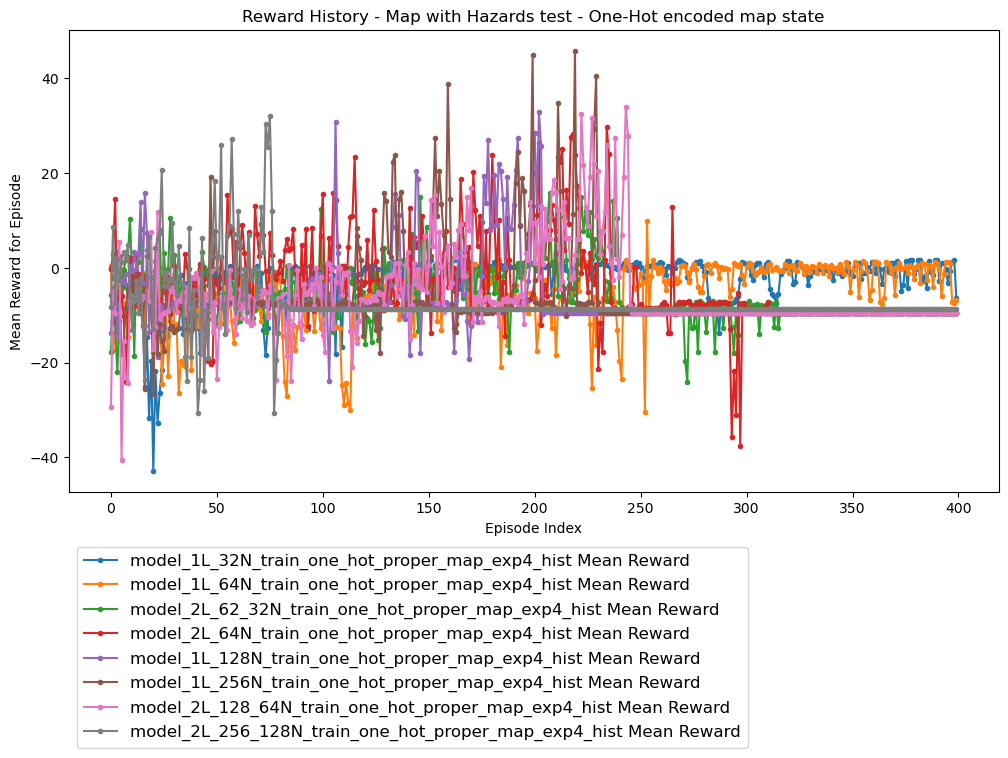

In [40]:
#one hot encoding with full map
print(one_hot_map_test_histories)
PlotRewardHistory(one_hot_map_test_histories, marker=".", title="Map with Hazards test - One-Hot encoded map state", save_fig=True)

In [41]:
#save histories proper level gen with hazards now, different single layer models
#proper level gen with hazards now, different single layer models
with open("one_hot_map_test_histories.pkl", "wb") as writer:
    pickle.dump(one_hot_map_test_histories, writer)

In [42]:
#proper level gen with hazards now, different single layer models
for key, value in one_hot_map_test_models.items():
  value.save(f"{key}_one_hot_map_test.keras")

performance drop after changing things to a full one hot encoded layer of channels - maybe tooo much irrelevant 0s and information
would probably be better with a CNN
have changed now the environment to take a rewardsettings object allowing for creation of custom reward values for future runs

# V4 New Reward Env Make

In [69]:
reward_settings = RewardSettings(exit_reward=50, unvisited_reward=0.2, wall_reward=0, stuck_reward=-2)
env = gym.make("GridWorld-v0", max_episode_steps=100, obs_mode="v4",
               init_map_options = MapOptions(cycle_bias=0.8, cluster_strength=0.5, cluster_type="distance", is_base_map=False, seed=1, hazard_level=5), 
               reward_settings = reward_settings).unwrapped


drawMap(env.get_map())

print(env.map)

env.get_obs()


Cycle bias, num edges, num cycles:  (0.8, 0, 53.0)
map before cycles
###############
#   #         #
##X # # ### ###
#     #   # # #
####### # X # #
#   #   # #   #
### # ##### # #
# #     # # # #
# ### # # #X# #
#   # #     # #
# # ### ####X##
# # # # #     #
### # X # # ###
#         #   #
###############
###############
#             #
# X     # #  ##
#             #
#     #   X   #
#             #
# S   #       #
#             #
#     #    X  #
#     #     # #
#     #    DX #
#     #       #
#   # X #   ###
#         #   #
###############


{'agent': <__main__.Node at 0x1f8e5fc1a30>,
 'target': <__main__.Node at 0x1f8e5fc06b0>,
 'tile_info': array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 1., 1., ..., 1., 1., 0.],
         [0., 1., 0., ..., 1., 0., 0.],
         ...,
         [0., 1., 1., ..., 0., 0., 0.],
         [0., 1., 1., ..., 1., 1., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 0., 0., ..., 0., 0., 1.],
         [1., 0., 0., ..., 0., 1., 1.],
         ...,
         [1., 0., 0., ..., 1., 1., 1.],
         [1., 0., 0., ..., 0., 0., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0

In [70]:
#now exp 3 with low learn, changing reward scheme a bit, punish being stuck
trainingConfigs = [TrainingConfig(n_iterations=200, n_max_steps=100, description="one_hot_exp3_newreward_low_learn", exploration_policy="boltzmann", exp_scale=3, learning_rate=0.001),
                   TrainingConfig(n_iterations=200, n_max_steps=100, description="one_hot_exp3_newreward_low_learn", exploration_policy="boltzmann", exp_scale=3, learning_rate=0.001),
                   TrainingConfig(n_iterations=200, n_max_steps=100, description="one_hot_exp3_newreward_low_learn", exploration_policy="boltzmann", exp_scale=3, learning_rate=0.001),
                   TrainingConfig(n_iterations=200, n_max_steps=100, description="one_hot_exp3_newreward_low_learn", exploration_policy="boltzmann", exp_scale=3, learning_rate=0.001)]
modelConfigs = [ModelConfig(layer_config=[32], activation="elu", description="1L_32N", n_inputs=1805),
                ModelConfig(layer_config=[64], activation="elu", description="1L_64N", n_inputs=1805),
                ModelConfig(layer_config=[128], activation="elu", description="1L_128N", n_inputs=1805),
                ModelConfig(layer_config=[64, 64], activation="elu", description="2L_64N", n_inputs=1805)]

In [71]:
#now exp 3 with low learn, changing reward scheme a bit, punish being stuck
env.reset()
one_hot_v4_newreward_histories, one_hot_v4_newreward_models = BuildAndTrainMultipleModels(env, trainingConfigs, modelConfigs)

c:\Users\anon\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


new model visited:  [(2, 6)]
new model obs - agent: (2, 6)
new model obs - exit: (11, 10)
iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
iteration  11
iteration  12
iteration  13
iteration  14
iteration  15
iteration  16
iteration  17
iteration  18
iteration  19
iteration  20
iteration  21
iteration  22
iteration  23
iteration  24
iteration  25
iteration  26
iteration  27
iteration  28
iteration  29
iteration  30
iteration  31
iteration  32
iteration  33
iteration  34
iteration  35
iteration  36
iteration  37
iteration  38
iteration  39
iteration  40
iteration  41
iteration  42
iteration  43
iteration  44
iteration  45
iteration  46
iteration  47
iteration  48
iteration  49
iteration  50
iteration  51
iteration  52
iteration  53
iteration  54
iteration  55
iteration  56
iteration  57
iteration  58
iteration  59
iteration  60
iteration  61
iteration  62
iteration  63
iteration  64
iteration 

In [72]:
#now exp 3 with low learn, changing reward scheme a bit, punish being stuck
for key, value in one_hot_v4_newreward_histories.items():
    env.render_history(value, True, True, save_path=f"{key}_heatmap_one_hot_v4_newreward.png")

C:\Users\anon\AppData\Local\Temp\ipykernel_7744\255380838.py:584: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("jet")


Heatmap saved as model_1L_32N_train_one_hot_exp3_newreward_low_learn_hist_heatmap_one_hot_v4_newreward.png
Heatmap saved as model_1L_64N_train_one_hot_exp3_newreward_low_learn_hist_heatmap_one_hot_v4_newreward.png
Heatmap saved as model_1L_128N_train_one_hot_exp3_newreward_low_learn_hist_heatmap_one_hot_v4_newreward.png
Heatmap saved as model_2L_64N_train_one_hot_exp3_newreward_low_learn_hist_heatmap_one_hot_v4_newreward.png


{'model_1L_32N_train_one_hot_exp3_newreward_low_learn_hist': <__main__.TrainingHistory object at 0x000001F87090CE90>, 'model_1L_64N_train_one_hot_exp3_newreward_low_learn_hist': <__main__.TrainingHistory object at 0x000001F8E603AE10>, 'model_1L_128N_train_one_hot_exp3_newreward_low_learn_hist': <__main__.TrainingHistory object at 0x000001F8EA378A10>, 'model_2L_64N_train_one_hot_exp3_newreward_low_learn_hist': <__main__.TrainingHistory object at 0x000001F88C0A8D40>}


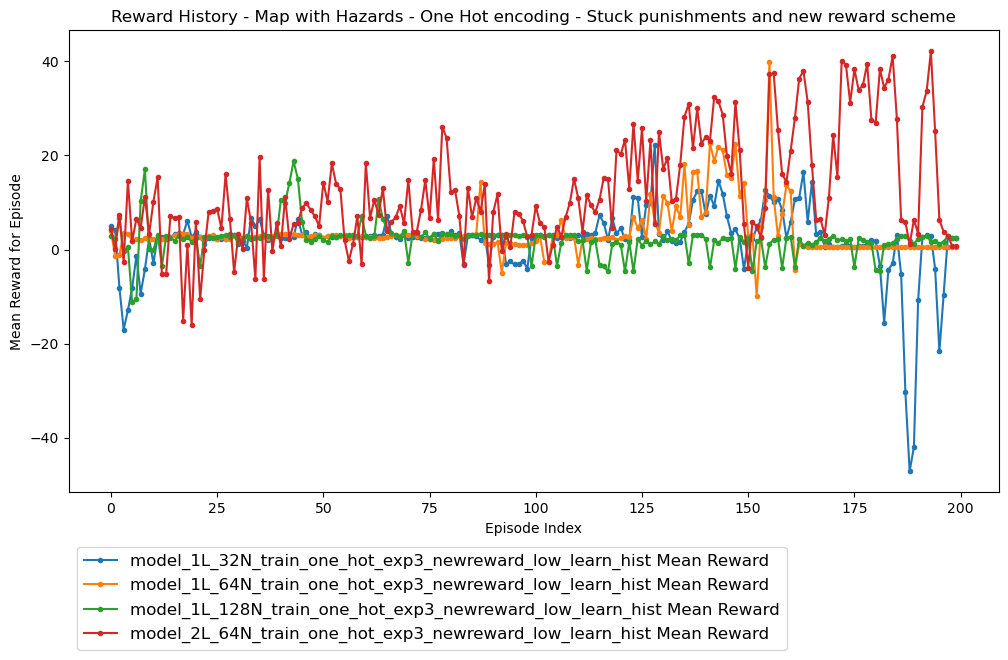

In [73]:
#now exp 3 with low learn, changing reward scheme a bit, punish being stuck
print(one_hot_v4_newreward_histories)
PlotRewardHistory(one_hot_v4_newreward_histories, marker=".", title="Map with Hazards - One Hot encoding - Stuck punishments and new reward scheme", save_fig=True)

In [74]:
#save histories #now exp 3 with low learn, changing reward scheme a bit, punish being stuck
with open("one_hot_v4_newreward_histories.pkl", "wb") as writer:
    pickle.dump(one_hot_v4_newreward_histories, writer)

In [75]:
#now exp 3 with low learn, changing reward scheme a bit, punish being stuck
for key, value in one_hot_v4_newreward_models.items():
  value.save(f"{key}_one_hot_v4_newreward.keras")